In [1]:
# Importando as bibliotecas necessárias
import pandas as pd
import numpy as np
import random
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from google.colab import drive
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
import os
from tqdm import tqdm
import pickle

In [2]:
# Carregar o drive

drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
#200 trials 'n_layers': 1, 'n_units_lstm1': 256, 'dropout_rate_lstm1': 0.0007260138620463863, 'activation_lstm1': 'relu', 'n_units_dense': 42, 'activation_dense': 'tanh', 'optimizer': 'adam', 'lookback': 11, 'batch_size': 128, 'learning_rate': 0.0020990690651314704}

'n_layers': 1, 'n_units_lstm1': 205, 'dropout_rate_lstm1': 0.16216244641644745, 'activation_lstm1': 'tanh', 'n_units_dense': 55, 'activation_dense': 'tanh', 'optimizer': 'sgd', 'lookback': 3, 'batch_size': 32, 'learning_rate': 0.004489228753135746

In [3]:
# 50 Trials

n_layers = 1
n_units_lstm1 = 205
dropout_rate_lstm1 = 0.16216244641644745
activation_lstm1 = 'tanh'
n_units_dense = 55
activation_dense = 'tanh'
optimizer = 'sgd'
lookback = 3
batch_size = 32
learning_rate = 0.004489228753135746

In [ ]:
'''# Definição de hiperparametros *Melhores apos 200 trials do optuna

n_layers = 1
n_units_lstm1 = 256
dropout_rate_lstm1 = 0.0007260138620463863
activation_lstm1 = 'relu'
n_units_dense = 42
activation_dense = 'tanh'
optimizer = 'adam'
lookback = 11
batch_size = 128
learning_rate = 0.0020990690651314704'''

In [4]:
#carregar base de dados
df = pd.read_csv("/content/drive/MyDrive/Mestrado/df_indice_brasil_endogenous_exogenous_red1.csv", sep=',')
df

,Unnamed: 0,Date,Close,High,Low,Volume,USD
0,0,2013-01-02,62550.10,62887.000000,60990.000000,3.739800e+06,2.045600
1,1,2013-01-03,63312.46,63473.000000,62341.000000,3.355800e+06,2.045600
2,2,2013-01-04,62523.06,63314.000000,62415.000000,6.233800e+06,2.048700
3,3,2013-01-07,61932.54,62699.000000,61639.000000,3.985800e+06,2.032400
4,4,2013-01-08,61127.84,62265.000000,61081.000000,3.840600e+06,2.026400
...,...,...,...,...,...,...,...
2719,2719,2023-12-21,132182.01,0.241381,0.239069,1.833553e+01,4.914600
2720,2720,2023-12-22,132752.93,0.120690,0.119534,9.167767e+00,4.881800
2721,2721,2023-12-26,133532.92,0.060345,0.059767,4.583883e+00,4.869744
2722,2722,2023-12-27,134193.72,0.030173,0.029884,2.291942e+00,4.813500


In [5]:
#carregar base de dados
# Selecionar apenas as colunas desejadas
df = df[['Date', 'Close', 'High', 'Low', 'Volume', 'USD']]

# Verificar as informações do DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2724 entries, 0 to 2723
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2724 non-null   object 
 1   Close   2724 non-null   float64
 2   High    2724 non-null   float64
 3   Low     2724 non-null   float64
 4   Volume  2724 non-null   float64
 5   USD     2724 non-null   float64
dtypes: float64(5), object(1)
memory usage: 127.8+ KB


In [6]:
#separação dos dados em treino, validação e teste
train_size = int(len(df['Close']) * 0.75)
val_size = int(len(df['Close']) * 0.85)

df_train = df.iloc[:train_size].copy()
df_test = df.iloc[val_size:].copy()

In [7]:
# Preparação dos dados de treino

# Normalização dos dados de treino
train_mean = df_train['Close'].mean()
train_std = df_train['Close'].std()

train_not_norm = df_train['Close'].to_numpy()

train_norm = (train_not_norm - train_mean) / train_std

# Preparação dos dados de treino
train_dataset = tf.keras.utils.timeseries_dataset_from_array(
    data=train_norm[:-1],
    targets=train_norm[lookback:],
    sequence_length=lookback,
    shuffle=False,
    batch_size=batch_size
)

# Preparação dos dados de teste

test_not_norm = df_test['Close'].to_numpy()

# Normalização dos dados de teste usando a média e desvio padrão dos dados de treino
test_norm = (test_not_norm - train_mean) / train_std

# Preparação dos dados de teste
validation_dataset = tf.keras.utils.timeseries_dataset_from_array(
    data=test_norm[:-1],
    targets=test_norm[lookback:],
    sequence_length=lookback,
    shuffle=False,
    batch_size=batch_size
)

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2043 entries, 0 to 2042
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2043 non-null   object 
 1   Close   2043 non-null   float64
 2   High    2043 non-null   float64
 3   Low     2043 non-null   float64
 4   Volume  2043 non-null   float64
 5   USD     2043 non-null   float64
dtypes: float64(5), object(1)
memory usage: 95.9+ KB


In [12]:
# Função para salvar os melhores resultados

def save_model(model, optimizer, metrics, seed, filename='bestresults'):
    # Salvar o modelo e suas métricas
    model.save(filename + '.keras')
    with open(filename + '.txt', 'w') as f:
        for key, value in metrics.items():
            f.write(f'{key}: {value}\n')
        f.write(f'Seed: {seed}\n')  # Salvar a seed

    # Salvar o otimizador
    with open(filename + '_optimizer.pkl', 'wb') as f:
        pickle.dump(optimizer.get_config(), f)

In [18]:
# Criação de diretório e salvar modelos e history
patience=10
runs=100
results_dir = f'/content/drive/MyDrive/LSTM/LSTM_p{patience}_bestresults_Close'

best_model = None
best_history = None
best_mape = float('inf')
all_metrics = []
all_history = []

In [19]:
# Loop para executar os runs
for run_num in tqdm(range(0, runs)):

    # Definir e armazenar a seed para cada trial
    seed = run_num
    random.seed(seed)
    tf.random.set_seed(seed)

    print("\nStarting Run", run_num, "with seed", seed)

    # Inicializar o modelo LSTM
    model = Sequential()
    model.add(LSTM(n_units_lstm1, activation=activation_lstm1, input_shape=(lookback, 1)))
    model.add(Dropout(dropout_rate_lstm1))
    model.add(Dense(n_units_dense, activation=activation_dense))
    model.add(Dense(1))

    # Cria uma instância do otimizador RMSprop com a taxa de aprendizado desejada
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)

    # Compila o modelo
    model.compile(optimizer=opt, loss='mae')

    # Definir os callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

    # Treinar o modelo
    history = model.fit(train_dataset, epochs=200, validation_data=validation_dataset, callbacks=[early_stopping], batch_size=batch_size, verbose=1)

    # Extrair a perda do histórico
    #loss = history.history['loss']

    # Fazer previsões
    val_predict = model.predict(validation_dataset)
    predict = (val_predict * train_std) + train_mean

   # Ajustar os dados de entrada e previstos para terem o mesmo tamanho
    y_real = test_not_norm[lookback:]
    y_predict = predict.squeeze()

    # Calcular métricas
    mae = mean_absolute_error(y_real, y_predict)
    mse = mean_squared_error(y_real, y_predict)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_real - y_predict) / y_real)) * 100
    r2 = r2_score(y_real, y_predict)

    # Imprimir as métricas
    print(f"Run {run_num}, Seed {seed}")
    print(f"MAE: {mae}, MSE: {mse}, RMSE: {rmse}, MAPE: {mape}, R2: {r2}")

    # Armazenar as métricas para cada run
    run_metrics = {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'MAPE': mape, 'R2': r2, 'Run': run_num}
    all_metrics.append(run_metrics)
    all_history.append(history)

    if mape < best_mape:
        best_mape = mape
        best_model = model
        best_history = history  # Atualiza o histórico do melhor modelo

        save_model(best_model, opt, run_metrics, seed, os.path.join(results_dir, 'best_model'))

        # Atualiza best_history apenas se um novo melhor modelo for encontrado
        best_history = history

    print(run_metrics)

  0%|          | 0/100 [00:00<?, ?it/s]


Starting Run 0 with seed 0
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.6238 - val_loss: 1.1443
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.4303 - val_loss: 0.2409
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.2304 - val_loss: 0.0763
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0692 - val_loss: 0.0710
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0511 - val_loss: 0.0691
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0513 - val_loss: 0.0708
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0507 - val_loss: 0.0692
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0493 - val_loss: 0.0692
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0489 - val_loss: 0.0689
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0504 - val_loss: 0.0688
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0482 - val_loss: 0.0687
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0

  1%|          | 1/100 [02:07<3:30:17, 127.44s/it]

{'MAE': 1401.085738146552, 'MSE': 2889659.0792903523, 'RMSE': 1699.899726245743, 'MAPE': 1.2579521140662728, 'R2': 0.9504618486441163, 'Run': 0}

Starting Run 1 with seed 1
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.5891 - val_loss: 1.0831
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.3954 - val_loss: 0.1932
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.2114 - val_loss: 0.0771
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0599 - val_loss: 0.0731
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0545 - val_loss: 0.0722
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0531 - val_loss: 0.0714
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0509 - val_loss: 0.0701
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0502 - val_loss: 0.0757
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0502 - val_loss: 0.0706
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0509 - val_loss: 0.0705
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0503 - val_loss: 0.0712
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0

  2%|▏         | 2/100 [04:21<3:34:47, 131.50s/it]

Run 1, Seed 1
MAE: 1396.532339901478, MSE: 2869408.3786640232, RMSE: 1693.9328140938835, MAPE: 1.2543299393960605, R2: 0.9508090114910692
{'MAE': 1396.532339901478, 'MSE': 2869408.3786640232, 'RMSE': 1693.9328140938835, 'MAPE': 1.2543299393960605, 'R2': 0.9508090114910692, 'Run': 1}

Starting Run 2 with seed 2
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.6208 - val_loss: 1.1638
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.4218 - val_loss: 0.2909
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.2266 - val_loss: 0.0784
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0712 - val_loss: 0.0702
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0495 - val_loss: 0.0702
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0490 - val_loss: 0.0699
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0495 - val_loss: 0.0706
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0498 - val_loss: 0.0691
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0501 - val_loss: 0.0697
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0474 - val_loss: 0.0685
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0468 - val_loss: 0.0698
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0

  3%|▎         | 3/100 [06:21<3:24:08, 126.27s/it]

Run 2, Seed 2
MAE: 1422.1475939039415, MSE: 2970528.7587705194, RMSE: 1723.5221956129603, MAPE: 1.274280411447357, R2: 0.9490754794177596
{'MAE': 1422.1475939039415, 'MSE': 2970528.7587705194, 'RMSE': 1723.5221956129603, 'MAPE': 1.274280411447357, 'R2': 0.9490754794177596, 'Run': 2}

Starting Run 3 with seed 3
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.6190 - val_loss: 1.2107
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.4294 - val_loss: 0.4143
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.2399 - val_loss: 0.0818
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0835 - val_loss: 0.0725
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0498 - val_loss: 0.0750
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0468 - val_loss: 0.0711
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0487 - val_loss: 0.0713
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0515 - val_loss: 0.0703
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0488 - val_loss: 0.0699
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0475 - val_loss: 0.0709
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0477 - val_loss: 0.0701
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0

  4%|▍         | 4/100 [08:32<3:24:29, 127.81s/it]

Run 3, Seed 3
MAE: 1422.4956450123154, MSE: 2974722.047835015, RMSE: 1724.7382548766684, MAPE: 1.2747587036452888, R2: 0.9490035928101509
{'MAE': 1422.4956450123154, 'MSE': 2974722.047835015, 'RMSE': 1724.7382548766684, 'MAPE': 1.2747587036452888, 'R2': 0.9490035928101509, 'Run': 3}

Starting Run 4 with seed 4
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.6390 - val_loss: 1.3046
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.4649 - val_loss: 0.6007
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.2740 - val_loss: 0.0876
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1152 - val_loss: 0.0729
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0507 - val_loss: 0.0715
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0495 - val_loss: 0.0709
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0508 - val_loss: 0.0709
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0482 - val_loss: 0.0704
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0474 - val_loss: 0.0715
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0483 - val_loss: 0.0763
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0491 - val_loss: 0.0707
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0

  5%|▌         | 5/100 [09:23<2:39:00, 100.43s/it]

Run 4, Seed 4
MAE: 1483.6008143472907, MSE: 3283182.74293254, RMSE: 1811.9555024703393, MAPE: 1.327636931963961, R2: 0.9437155736418706
{'MAE': 1483.6008143472907, 'MSE': 3283182.74293254, 'RMSE': 1811.9555024703393, 'MAPE': 1.327636931963961, 'R2': 0.9437155736418706, 'Run': 4}

Starting Run 5 with seed 5
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.5687 - val_loss: 1.0034
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.3867 - val_loss: 0.1146
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1989 - val_loss: 0.0706
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0482 - val_loss: 0.0691
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0490 - val_loss: 0.0678
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0478 - val_loss: 0.0674
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0480 - val_loss: 0.0680
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0475 - val_loss: 0.0678
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0465 - val_loss: 0.0677
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0477 - val_loss: 0.0690
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0446 - val_loss: 0.0668
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0

  6%|▌         | 6/100 [10:43<2:26:19, 93.40s/it] 

Run 5, Seed 5
MAE: 1427.2804903017243, MSE: 3004201.3155097202, RMSE: 1733.263198567869, MAPE: 1.281604656904928, R2: 0.9484982223204637
{'MAE': 1427.2804903017243, 'MSE': 3004201.3155097202, 'RMSE': 1733.263198567869, 'MAPE': 1.281604656904928, 'R2': 0.9484982223204637, 'Run': 5}

Starting Run 6 with seed 6
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.6261 - val_loss: 1.2399
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.4520 - val_loss: 0.4454
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.2636 - val_loss: 0.0797
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0943 - val_loss: 0.0690
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0471 - val_loss: 0.0680
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0502 - val_loss: 0.0680
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0491 - val_loss: 0.0676
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0463 - val_loss: 0.0675
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0477 - val_loss: 0.0680
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0468 - val_loss: 0.0671
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0466 - val_loss: 0.0670
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0

  7%|▋         | 7/100 [12:41<2:37:00, 101.30s/it]

Run 6, Seed 6
MAE: 1401.378957050493, MSE: 2880981.5154003985, RMSE: 1697.345431961449, MAPE: 1.2556802255674497, R2: 0.9506106103013172
{'MAE': 1401.378957050493, 'MSE': 2880981.5154003985, 'RMSE': 1697.345431961449, 'MAPE': 1.2556802255674497, 'R2': 0.9506106103013172, 'Run': 6}

Starting Run 7 with seed 7
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.5852 - val_loss: 1.0669
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.3891 - val_loss: 0.1794
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.2018 - val_loss: 0.0764
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0583 - val_loss: 0.0717
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0509 - val_loss: 0.0715
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0507 - val_loss: 0.0695
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0497 - val_loss: 0.0692
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0489 - val_loss: 0.0691
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0504 - val_loss: 0.0702
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0474 - val_loss: 0.0685
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0483 - val_loss: 0.0689
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0

  8%|▊         | 8/100 [14:48<2:47:59, 109.56s/it]

Run 7, Seed 7
MAE: 1401.604732912562, MSE: 2884319.3116539945, RMSE: 1698.3283874604447, MAPE: 1.2566637905581408, R2: 0.9505533896218292
{'MAE': 1401.604732912562, 'MSE': 2884319.3116539945, 'RMSE': 1698.3283874604447, 'MAPE': 1.2566637905581408, 'R2': 0.9505533896218292, 'Run': 7}

Starting Run 8 with seed 8
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.5911 - val_loss: 1.0675
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.3846 - val_loss: 0.1709
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1991 - val_loss: 0.0739
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0559 - val_loss: 0.0697
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0497 - val_loss: 0.0693
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0472 - val_loss: 0.0688
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0488 - val_loss: 0.0694
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0487 - val_loss: 0.0683
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0494 - val_loss: 0.0696
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0499 - val_loss: 0.0681
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0466 - val_loss: 0.0674
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0

  9%|▉         | 9/100 [16:57<2:55:26, 115.68s/it]

Run 8, Seed 8
MAE: 1403.4518626847291, MSE: 2892557.422429189, RMSE: 1700.7520167352998, MAPE: 1.257476017921988, R2: 0.9504121616197465
{'MAE': 1403.4518626847291, 'MSE': 2892557.422429189, 'RMSE': 1700.7520167352998, 'MAPE': 1.257476017921988, 'R2': 0.9504121616197465, 'Run': 8}

Starting Run 9 with seed 9
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.6314 - val_loss: 1.2860
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.4435 - val_loss: 0.5508
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.2567 - val_loss: 0.0861
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1029 - val_loss: 0.0728
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0504 - val_loss: 0.0732
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0508 - val_loss: 0.0705
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0504 - val_loss: 0.0709
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0514 - val_loss: 0.0703
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0505 - val_loss: 0.0716
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0485 - val_loss: 0.0701
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0497 - val_loss: 0.0699
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0

 10%|█         | 10/100 [19:29<3:10:14, 126.83s/it]

Run 9, Seed 9
MAE: 1421.991856527094, MSE: 2986342.8217285294, RMSE: 1728.103822612672, MAPE: 1.2778170903912724, R2: 0.9488043749646496
{'MAE': 1421.991856527094, 'MSE': 2986342.8217285294, 'RMSE': 1728.103822612672, 'MAPE': 1.2778170903912724, 'R2': 0.9488043749646496, 'Run': 9}

Starting Run 10 with seed 10
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.5347 - val_loss: 0.9477
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.3546 - val_loss: 0.1232
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1856 - val_loss: 0.0758
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0517 - val_loss: 0.0704
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0501 - val_loss: 0.0703
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0501 - val_loss: 0.0706
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0496 - val_loss: 0.0693
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0513 - val_loss: 0.0692
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0485 - val_loss: 0.0689
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0503 - val_loss: 0.0697
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0497 - val_loss: 0.0690
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0

 11%|█         | 11/100 [21:05<2:54:20, 117.54s/it]

Run 10, Seed 10
MAE: 1427.6154533559118, MSE: 3009120.868330519, RMSE: 1734.6817772521042, MAPE: 1.2755739063553189, R2: 0.948413885190874
{'MAE': 1427.6154533559118, 'MSE': 3009120.868330519, 'RMSE': 1734.6817772521042, 'MAPE': 1.2755739063553189, 'R2': 0.948413885190874, 'Run': 10}

Starting Run 11 with seed 11
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.5797 - val_loss: 0.9984
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.3939 - val_loss: 0.1128
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.2036 - val_loss: 0.0703
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0542 - val_loss: 0.0687
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0512 - val_loss: 0.0681
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0496 - val_loss: 0.0682
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0504 - val_loss: 0.0716
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0499 - val_loss: 0.0700
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0489 - val_loss: 0.0677
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0481 - val_loss: 0.0688
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0503 - val_loss: 0.0675
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0

 12%|█▏        | 12/100 [22:16<2:31:25, 103.24s/it]

Run 11, Seed 11
MAE: 1427.329310344828, MSE: 2993728.763907599, RMSE: 1730.2395105613555, MAPE: 1.2765476655029762, R2: 0.9486777559028389
{'MAE': 1427.329310344828, 'MSE': 2993728.763907599, 'RMSE': 1730.2395105613555, 'MAPE': 1.2765476655029762, 'R2': 0.9486777559028389, 'Run': 11}

Starting Run 12 with seed 12
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.6227 - val_loss: 1.1672
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.4264 - val_loss: 0.2974
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.2270 - val_loss: 0.0783
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0737 - val_loss: 0.0703
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0517 - val_loss: 0.0705
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0520 - val_loss: 0.0702
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0523 - val_loss: 0.0695
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0503 - val_loss: 0.0692
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0512 - val_loss: 0.0703
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0529 - val_loss: 0.0689
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0507 - val_loss: 0.0691
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0

 13%|█▎        | 13/100 [23:11<2:08:28, 88.61s/it] 

Run 12, Seed 12
MAE: 1447.5041279248771, MSE: 3100404.6037332667, RMSE: 1760.7965821562884, MAPE: 1.295636134813088, R2: 0.9468489851882681
{'MAE': 1447.5041279248771, 'MSE': 3100404.6037332667, 'RMSE': 1760.7965821562884, 'MAPE': 1.295636134813088, 'R2': 0.9468489851882681, 'Run': 12}

Starting Run 13 with seed 13
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.5768 - val_loss: 0.9280
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.3780 - val_loss: 0.0986
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.1923 - val_loss: 0.0708
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0530 - val_loss: 0.0683
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0517 - val_loss: 0.0677
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0498 - val_loss: 0.0671
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0482 - val_loss: 0.0670
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0497 - val_loss: 0.0672
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0511 - val_loss: 0.0669
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0508 - val_loss: 0.0666
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0500 - val_loss: 0.0661
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0

 14%|█▍        | 14/100 [24:20<1:58:41, 82.81s/it]

Run 13, Seed 13
MAE: 1419.2544619766015, MSE: 2970525.490298172, RMSE: 1723.5212474170928, MAPE: 1.2753502656834024, R2: 0.949075535450002
{'MAE': 1419.2544619766015, 'MSE': 2970525.490298172, 'RMSE': 1723.5212474170928, 'MAPE': 1.2753502656834024, 'R2': 0.949075535450002, 'Run': 13}

Starting Run 14 with seed 14
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.5826 - val_loss: 1.1250
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.4107 - val_loss: 0.3281
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.2348 - val_loss: 0.0769
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0777 - val_loss: 0.0696
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0502 - val_loss: 0.0691
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0502 - val_loss: 0.0695
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0503 - val_loss: 0.0681
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0481 - val_loss: 0.0686
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0484 - val_loss: 0.0683
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0477 - val_loss: 0.0680
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0492 - val_loss: 0.0684
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0

 15%|█▌        | 15/100 [26:32<2:18:14, 97.58s/it]

Run 14, Seed 14
MAE: 1413.1977293719217, MSE: 2936704.428902981, RMSE: 1713.6815424410047, MAPE: 1.2636458170196767, R2: 0.9496553383999137
{'MAE': 1413.1977293719217, 'MSE': 2936704.428902981, 'RMSE': 1713.6815424410047, 'MAPE': 1.2636458170196767, 'R2': 0.9496553383999137, 'Run': 14}

Starting Run 15 with seed 15
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.5925 - val_loss: 1.0699
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.4030 - val_loss: 0.1612
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.2168 - val_loss: 0.0753
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0583 - val_loss: 0.0707
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0536 - val_loss: 0.0710
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0508 - val_loss: 0.0699
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0506 - val_loss: 0.0691
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0488 - val_loss: 0.0689
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0483 - val_loss: 0.0691
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0501 - val_loss: 0.0685
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0498 - val_loss: 0.0689
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0

 16%|█▌        | 16/100 [27:43<2:05:25, 89.59s/it]

Run 15, Seed 15
MAE: 1440.0223475985224, MSE: 3058839.9700761307, RMSE: 1748.9539645388413, MAPE: 1.2890555901458833, R2: 0.9475615381423227
{'MAE': 1440.0223475985224, 'MSE': 3058839.9700761307, 'RMSE': 1748.9539645388413, 'MAPE': 1.2890555901458833, 'R2': 0.9475615381423227, 'Run': 15}

Starting Run 16 with seed 16
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.6268 - val_loss: 1.2454
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.4426 - val_loss: 0.4687
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.2603 - val_loss: 0.0832
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0959 - val_loss: 0.0706
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0494 - val_loss: 0.0728
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0516 - val_loss: 0.0690
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0491 - val_loss: 0.0694
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0527 - val_loss: 0.0692
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0488 - val_loss: 0.0713
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0491 - val_loss: 0.0693
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0478 - val_loss: 0.0692
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0

 17%|█▋        | 17/100 [29:51<2:19:46, 101.04s/it]

Run 16, Seed 16
MAE: 1426.0572028940892, MSE: 2997427.6978861885, RMSE: 1731.3080886676953, MAPE: 1.2745849308323596, R2: 0.9486143441486289
{'MAE': 1426.0572028940892, 'MSE': 2997427.6978861885, 'RMSE': 1731.3080886676953, 'MAPE': 1.2745849308323596, 'R2': 0.9486143441486289, 'Run': 16}

Starting Run 17 with seed 17
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.6530 - val_loss: 1.3687
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.4745 - val_loss: 0.7443
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.2838 - val_loss: 0.0947
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1305 - val_loss: 0.0744
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0501 - val_loss: 0.0727
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0495 - val_loss: 0.0725
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0511 - val_loss: 0.0720
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0505 - val_loss: 0.0753
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0490 - val_loss: 0.0713
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0474 - val_loss: 0.0715
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0484 - val_loss: 0.0715
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0

 18%|█▊        | 18/100 [31:31<2:17:55, 100.93s/it]

Run 17, Seed 17
MAE: 1465.9554518165028, MSE: 3195372.3646794017, RMSE: 1787.560450636398, MAPE: 1.312589641826063, R2: 0.9452209290105011
{'MAE': 1465.9554518165028, 'MSE': 3195372.3646794017, 'RMSE': 1787.560450636398, 'MAPE': 1.312589641826063, 'R2': 0.9452209290105011, 'Run': 17}

Starting Run 18 with seed 18
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.6338 - val_loss: 1.2305
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.4344 - val_loss: 0.4056
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.2383 - val_loss: 0.0833
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0836 - val_loss: 0.0728
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0529 - val_loss: 0.0716
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0511 - val_loss: 0.0710
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0514 - val_loss: 0.0708
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0512 - val_loss: 0.0717
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0510 - val_loss: 0.0706
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0505 - val_loss: 0.0701
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0500 - val_loss: 0.0704
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0

 19%|█▉        | 19/100 [33:48<2:30:48, 111.71s/it]

Run 18, Seed 18
MAE: 1423.8223475985226, MSE: 2984717.9641466765, RMSE: 1727.6336313427903, MAPE: 1.277031560394463, R2: 0.9488322303062705
{'MAE': 1423.8223475985226, 'MSE': 2984717.9641466765, 'RMSE': 1727.6336313427903, 'MAPE': 1.277031560394463, 'R2': 0.9488322303062705, 'Run': 18}

Starting Run 19 with seed 19
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.6533 - val_loss: 1.3133
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.4687 - val_loss: 0.5590
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.2749 - val_loss: 0.0861
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1109 - val_loss: 0.0717
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0521 - val_loss: 0.0709
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0519 - val_loss: 0.0707
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0509 - val_loss: 0.0708
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0501 - val_loss: 0.0714
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0487 - val_loss: 0.0704
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0498 - val_loss: 0.0716
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0514 - val_loss: 0.0695
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0

 20%|██        | 20/100 [35:45<2:30:52, 113.15s/it]

Run 19, Seed 19
MAE: 1432.4310267857147, MSE: 3027058.8813552703, RMSE: 1739.8444991881518, MAPE: 1.284837237807746, R2: 0.9481063693283238
{'MAE': 1432.4310267857147, 'MSE': 3027058.8813552703, 'RMSE': 1739.8444991881518, 'MAPE': 1.284837237807746, 'R2': 0.9481063693283238, 'Run': 19}

Starting Run 20 with seed 20
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.5709 - val_loss: 0.8990
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.3584 - val_loss: 0.0907
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.1695 - val_loss: 0.0721
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0506 - val_loss: 0.0683
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0481 - val_loss: 0.0685
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0488 - val_loss: 0.0679
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0491 - val_loss: 0.0683
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0496 - val_loss: 0.0678
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0492 - val_loss: 0.0677
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0486 - val_loss: 0.0691
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0478 - val_loss: 0.0689
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0

 21%|██        | 21/100 [36:53<2:11:03, 99.53s/it] 


MAE: 1442.7840047721677, MSE: 3064935.7036580523, RMSE: 1750.6957770149709, MAPE: 1.2923397344668093, R2: 0.9474570374505384
{'MAE': 1442.7840047721677, 'MSE': 3064935.7036580523, 'RMSE': 1750.6957770149709, 'MAPE': 1.2923397344668093, 'R2': 0.9474570374505384, 'Run': 20}

Starting Run 21 with seed 21
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.5422 - val_loss: 0.8561
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.3503 - val_loss: 0.0880
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1755 - val_loss: 0.0678
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0506 - val_loss: 0.0669
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0502 - val_loss: 0.0679
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0490 - val_loss: 0.0670
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0493 - val_loss: 0.0666
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0501 - val_loss: 0.0671
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0492 - val_loss: 0.0666
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0490 - val_loss: 0.0657
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0491 - val_loss: 0.0661
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0

 22%|██▏       | 22/100 [37:52<1:53:52, 87.60s/it]

Run 21, Seed 21
MAE: 1423.590902863301, MSE: 2980355.5384770874, RMSE: 1726.3706260467616, MAPE: 1.2742804062666777, R2: 0.9489070164651803
{'MAE': 1423.590902863301, 'MSE': 2980355.5384770874, 'RMSE': 1726.3706260467616, 'MAPE': 1.2742804062666777, 'R2': 0.9489070164651803, 'Run': 21}

Starting Run 22 with seed 22
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.5885 - val_loss: 1.0213
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.4002 - val_loss: 0.1105
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.2062 - val_loss: 0.0689
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0534 - val_loss: 0.0669
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0482 - val_loss: 0.0662
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0486 - val_loss: 0.0709
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0482 - val_loss: 0.0656
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0473 - val_loss: 0.0657
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0491 - val_loss: 0.0660
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0481 - val_loss: 0.0658
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0463 - val_loss: 0.0670
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0

 23%|██▎       | 23/100 [39:03<1:45:51, 82.49s/it]

Run 22, Seed 22
MAE: 1407.8917564655176, MSE: 2914690.2469634456, RMSE: 1707.2463931616448, MAPE: 1.2644925811632897, R2: 0.9500327330499304
{'MAE': 1407.8917564655176, 'MSE': 2914690.2469634456, 'RMSE': 1707.2463931616448, 'MAPE': 1.2644925811632897, 'R2': 0.9500327330499304, 'Run': 22}

Starting Run 23 with seed 23
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.6288 - val_loss: 1.2148
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.4275 - val_loss: 0.3950
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.2253 - val_loss: 0.0802
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0798 - val_loss: 0.0706
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0486 - val_loss: 0.0698
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0497 - val_loss: 0.0697
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0501 - val_loss: 0.0705
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0491 - val_loss: 0.0696
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0508 - val_loss: 0.0697
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0482 - val_loss: 0.0702
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0476 - val_loss: 0.0733
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0

 24%|██▍       | 24/100 [41:15<2:03:20, 97.37s/it]

Run 23, Seed 23
MAE: 1432.977209821429, MSE: 3026305.6052508587, RMSE: 1739.6280077220126, MAPE: 1.2815497237995785, R2: 0.9481192829297727
{'MAE': 1432.977209821429, 'MSE': 3026305.6052508587, 'RMSE': 1739.6280077220126, 'MAPE': 1.2815497237995785, 'R2': 0.9481192829297727, 'Run': 23}

Starting Run 24 with seed 24
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.6401 - val_loss: 1.1825
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.4346 - val_loss: 0.2650
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.2290 - val_loss: 0.0775
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0684 - val_loss: 0.0705
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0491 - val_loss: 0.0698
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0512 - val_loss: 0.0732
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0518 - val_loss: 0.0690
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0504 - val_loss: 0.0688
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0487 - val_loss: 0.0692
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0489 - val_loss: 0.0685
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0498 - val_loss: 0.0684
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0

 25%|██▌       | 25/100 [44:09<2:30:33, 120.45s/it]

Run 24, Seed 24
MAE: 1397.5803009544338, MSE: 2886332.734097445, RMSE: 1698.9210499895057, MAPE: 1.25710007974143, R2: 0.9505188730151949
{'MAE': 1397.5803009544338, 'MSE': 2886332.734097445, 'RMSE': 1698.9210499895057, 'MAPE': 1.25710007974143, 'R2': 0.9505188730151949, 'Run': 24}

Starting Run 25 with seed 25
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.5730 - val_loss: 1.0084
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.3804 - val_loss: 0.1202
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1994 - val_loss: 0.0712
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0520 - val_loss: 0.0690
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0481 - val_loss: 0.0690
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0490 - val_loss: 0.0690
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0495 - val_loss: 0.0683
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0474 - val_loss: 0.0681
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0494 - val_loss: 0.0679
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0480 - val_loss: 0.0700
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0486 - val_loss: 0.0673
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0

 26%|██▌       | 26/100 [45:51<2:21:32, 114.76s/it]

Run 25, Seed 25
MAE: 1416.219508158867, MSE: 2954671.452135637, RMSE: 1718.9157780809498, MAPE: 1.272328366039978, R2: 0.9493473252080832
{'MAE': 1416.219508158867, 'MSE': 2954671.452135637, 'RMSE': 1718.9157780809498, 'MAPE': 1.272328366039978, 'R2': 0.9493473252080832, 'Run': 25}

Starting Run 26 with seed 26
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.6114 - val_loss: 1.1977
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.4176 - val_loss: 0.4096
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.2239 - val_loss: 0.0788
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0805 - val_loss: 0.0699
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0482 - val_loss: 0.0694
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0492 - val_loss: 0.0692
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0493 - val_loss: 0.0690
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0482 - val_loss: 0.0699
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0484 - val_loss: 0.0691
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0476 - val_loss: 0.0683
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0488 - val_loss: 0.0697
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0

 27%|██▋       | 27/100 [48:57<2:45:37, 136.12s/it]

Run 26, Seed 26
MAE: 1404.7211891933503, MSE: 2897539.090355852, RMSE: 1702.2159352901888, MAPE: 1.2598727526172622, R2: 0.9503267596352964
{'MAE': 1404.7211891933503, 'MSE': 2897539.090355852, 'RMSE': 1702.2159352901888, 'MAPE': 1.2598727526172622, 'R2': 0.9503267596352964, 'Run': 26}

Starting Run 27 with seed 27
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.5947 - val_loss: 0.9229
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.3763 - val_loss: 0.0932
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1812 - val_loss: 0.0695
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0546 - val_loss: 0.0674
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0507 - val_loss: 0.0669
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0508 - val_loss: 0.0668
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0476 - val_loss: 0.0667
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0496 - val_loss: 0.0670
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0494 - val_loss: 0.0662
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0478 - val_loss: 0.0669
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0487 - val_loss: 0.0666
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0

 28%|██▊       | 28/100 [49:46<2:11:59, 110.00s/it]

Run 27, Seed 27
MAE: 1435.342762469212, MSE: 3040091.0552310036, RMSE: 1743.5856890990485, MAPE: 1.284286350258172, R2: 0.9478829554984436
{'MAE': 1435.342762469212, 'MSE': 3040091.0552310036, 'RMSE': 1743.5856890990485, 'MAPE': 1.284286350258172, 'R2': 0.9478829554984436, 'Run': 27}

Starting Run 28 with seed 28
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.6057 - val_loss: 1.2038
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.4269 - val_loss: 0.4324
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.2390 - val_loss: 0.0834
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0897 - val_loss: 0.0714
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0493 - val_loss: 0.0708
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0496 - val_loss: 0.0713
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0502 - val_loss: 0.0705
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0495 - val_loss: 0.0705
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0479 - val_loss: 0.0711
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0488 - val_loss: 0.0706
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0498 - val_loss: 0.0699
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0

 29%|██▉       | 29/100 [52:42<2:33:46, 129.96s/it]

Run 28, Seed 28
MAE: 1409.381073737685, MSE: 2916859.3918618746, RMSE: 1707.8815508874948, MAPE: 1.2618748854209139, R2: 0.9499955468541397
{'MAE': 1409.381073737685, 'MSE': 2916859.3918618746, 'RMSE': 1707.8815508874948, 'MAPE': 1.2618748854209139, 'R2': 0.9499955468541397, 'Run': 28}

Starting Run 29 with seed 29
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.6433 - val_loss: 1.2106
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.4357 - val_loss: 0.3163
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.2322 - val_loss: 0.0795
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0700 - val_loss: 0.0708
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0513 - val_loss: 0.0712
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0499 - val_loss: 0.0706
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0484 - val_loss: 0.0700
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0514 - val_loss: 0.0700
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0460 - val_loss: 0.0693
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0492 - val_loss: 0.0695
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0490 - val_loss: 0.0715
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0

 30%|███       | 30/100 [54:22<2:21:10, 121.01s/it]

Run 29, Seed 29
MAE: 1438.4454256465522, MSE: 3060269.52682636, RMSE: 1749.3626058728819, MAPE: 1.285508886913205, R2: 0.9475370308919095
{'MAE': 1438.4454256465522, 'MSE': 3060269.52682636, 'RMSE': 1749.3626058728819, 'MAPE': 1.285508886913205, 'R2': 0.9475370308919095, 'Run': 29}

Starting Run 30 with seed 30
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.5776 - val_loss: 1.0770
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.3882 - val_loss: 0.2215
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.2062 - val_loss: 0.0744
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0625 - val_loss: 0.0688
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0480 - val_loss: 0.0685
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0472 - val_loss: 0.0685
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0498 - val_loss: 0.0682
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0479 - val_loss: 0.0686
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0465 - val_loss: 0.0684
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0470 - val_loss: 0.0675
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0469 - val_loss: 0.0677
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0

 31%|███       | 31/100 [56:34<2:22:40, 124.06s/it]

Run 30, Seed 30
MAE: 1398.9762115147787, MSE: 2874822.3359708157, RMSE: 1695.53010470791, MAPE: 1.2551478368745448, R2: 0.9507161986612028
{'MAE': 1398.9762115147787, 'MSE': 2874822.3359708157, 'RMSE': 1695.53010470791, 'MAPE': 1.2551478368745448, 'R2': 0.9507161986612028, 'Run': 30}

Starting Run 31 with seed 31
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.5705 - val_loss: 1.0419
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.3803 - val_loss: 0.1657
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1984 - val_loss: 0.0739
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0573 - val_loss: 0.0703
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0496 - val_loss: 0.0696
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0502 - val_loss: 0.0702
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0489 - val_loss: 0.0745
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0515 - val_loss: 0.0704
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0478 - val_loss: 0.0690
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0483 - val_loss: 0.0685
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0486 - val_loss: 0.0692
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0

 32%|███▏      | 32/100 [58:08<2:10:23, 115.05s/it]

Run 31, Seed 31
MAE: 1423.8317987992614, MSE: 2980202.315764781, RMSE: 1726.3262483565443, MAPE: 1.2763167408473601, R2: 0.9489096432006204
{'MAE': 1423.8317987992614, 'MSE': 2980202.315764781, 'RMSE': 1726.3262483565443, 'MAPE': 1.2763167408473601, 'R2': 0.9489096432006204, 'Run': 31}

Starting Run 32 with seed 32
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.5611 - val_loss: 1.0044
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.3830 - val_loss: 0.1383
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.2004 - val_loss: 0.0714
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0553 - val_loss: 0.0687
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0502 - val_loss: 0.0692
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0487 - val_loss: 0.0679
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0484 - val_loss: 0.0678
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0502 - val_loss: 0.0678
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0485 - val_loss: 0.0675
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0488 - val_loss: 0.0677
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0478 - val_loss: 0.0673
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0

 33%|███▎      | 33/100 [59:14<1:52:18, 100.58s/it]

Run 32, Seed 32
MAE: 1423.2882720135472, MSE: 2974947.705126383, RMSE: 1724.8036714728962, MAPE: 1.2768976277457582, R2: 0.9489997243105295
{'MAE': 1423.2882720135472, 'MSE': 2974947.705126383, 'RMSE': 1724.8036714728962, 'MAPE': 1.2768976277457582, 'R2': 0.9489997243105295, 'Run': 32}

Starting Run 33 with seed 33
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.6538 - val_loss: 1.3912
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.4889 - val_loss: 0.8052
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.3049 - val_loss: 0.1107
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1485 - val_loss: 0.0744
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0492 - val_loss: 0.0718
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0486 - val_loss: 0.0720
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0481 - val_loss: 0.0723
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0469 - val_loss: 0.0715
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0481 - val_loss: 0.0710
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0468 - val_loss: 0.0728
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0472 - val_loss: 0.0711
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0

 34%|███▍      | 34/100 [1:02:29<2:21:40, 128.80s/it]

Run 33, Seed 33
MAE: 1422.1657273706899, MSE: 2974089.2802313883, RMSE: 1724.5548063866768, MAPE: 1.2740182599634524, R2: 0.9490144405041042
{'MAE': 1422.1657273706899, 'MSE': 2974089.2802313883, 'RMSE': 1724.5548063866768, 'MAPE': 1.2740182599634524, 'R2': 0.9490144405041042, 'Run': 33}

Starting Run 34 with seed 34
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.5744 - val_loss: 1.0031
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.3847 - val_loss: 0.1153
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.2026 - val_loss: 0.0728
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0520 - val_loss: 0.0699
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0496 - val_loss: 0.0697
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0495 - val_loss: 0.0695
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0509 - val_loss: 0.0707
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0495 - val_loss: 0.0684
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0493 - val_loss: 0.0684
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0487 - val_loss: 0.0677
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0469 - val_loss: 0.0678
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0

 35%|███▌      | 35/100 [1:03:47<2:03:01, 113.56s/it]

Run 34, Seed 34
MAE: 1427.9676246921185, MSE: 3000462.315048, RMSE: 1732.1842612863102, MAPE: 1.2787187218383185, R2: 0.948562320944457
{'MAE': 1427.9676246921185, 'MSE': 3000462.315048, 'RMSE': 1732.1842612863102, 'MAPE': 1.2787187218383185, 'R2': 0.948562320944457, 'Run': 34}

Starting Run 35 with seed 35
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.6485 - val_loss: 1.1882
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.4303 - val_loss: 0.2405
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.2280 - val_loss: 0.0776
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0617 - val_loss: 0.0711
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0495 - val_loss: 0.0717
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0493 - val_loss: 0.0709
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0517 - val_loss: 0.0714
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0505 - val_loss: 0.0702
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0504 - val_loss: 0.0697
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0476 - val_loss: 0.0693
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0498 - val_loss: 0.0706
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0

 36%|███▌      | 36/100 [1:05:25<1:56:07, 108.87s/it]

Run 35, Seed 35
MAE: 1438.1725931342369, MSE: 3048590.4101762585, RMSE: 1746.0213086260599, MAPE: 1.2870523453308633, R2: 0.9477372489219402
{'MAE': 1438.1725931342369, 'MSE': 3048590.4101762585, 'RMSE': 1746.0213086260599, 'MAPE': 1.2870523453308633, 'R2': 0.9477372489219402, 'Run': 35}

Starting Run 36 with seed 36
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.6205 - val_loss: 1.2451
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.4352 - val_loss: 0.4943
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.2479 - val_loss: 0.0836
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0929 - val_loss: 0.0715
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0490 - val_loss: 0.0711
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0482 - val_loss: 0.0721
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0480 - val_loss: 0.0709
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0477 - val_loss: 0.0721
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0456 - val_loss: 0.0743
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0466 - val_loss: 0.0704
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0471 - val_loss: 0.0697
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0

 37%|███▋      | 37/100 [1:08:30<2:18:24, 131.82s/it]

Run 36, Seed 36
MAE: 1423.704562807882, MSE: 2986285.456134462, RMSE: 1728.0872246893273, MAPE: 1.276973011011952, R2: 0.9488053583974365
{'MAE': 1423.704562807882, 'MSE': 2986285.456134462, 'RMSE': 1728.0872246893273, 'MAPE': 1.276973011011952, 'R2': 0.9488053583974365, 'Run': 36}

Starting Run 37 with seed 37
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.6040 - val_loss: 1.1756
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.4169 - val_loss: 0.3572
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.2304 - val_loss: 0.0801
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0746 - val_loss: 0.0711
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0494 - val_loss: 0.0705
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0478 - val_loss: 0.0713
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0484 - val_loss: 0.0730
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0462 - val_loss: 0.0706
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0488 - val_loss: 0.0695
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0470 - val_loss: 0.0701
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0469 - val_loss: 0.0697
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0

 38%|███▊      | 38/100 [1:11:42<2:34:49, 149.83s/it]

Run 37, Seed 37
MAE: 1406.3391248460593, MSE: 2907715.9885590007, RMSE: 1705.2026239010427, MAPE: 1.2597372896702406, R2: 0.9501522945133953
{'MAE': 1406.3391248460593, 'MSE': 2907715.9885590007, 'RMSE': 1705.2026239010427, 'MAPE': 1.2597372896702406, 'R2': 0.9501522945133953, 'Run': 37}

Starting Run 38 with seed 38
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.5721 - val_loss: 1.0290
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.3855 - val_loss: 0.1419
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1986 - val_loss: 0.0771
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0574 - val_loss: 0.0715
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0548 - val_loss: 0.0716
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0516 - val_loss: 0.0713
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0505 - val_loss: 0.0711
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0512 - val_loss: 0.0708
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0520 - val_loss: 0.0707
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0498 - val_loss: 0.0705
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0514 - val_loss: 0.0692
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0

 39%|███▉      | 39/100 [1:13:38<2:21:58, 139.64s/it]

Run 38, Seed 38
MAE: 1420.5750608066505, MSE: 2972328.7425500266, RMSE: 1724.044298314294, MAPE: 1.2751498436105957, R2: 0.949044621843748
{'MAE': 1420.5750608066505, 'MSE': 2972328.7425500266, 'RMSE': 1724.044298314294, 'MAPE': 1.2751498436105957, 'R2': 0.949044621843748, 'Run': 38}

Starting Run 39 with seed 39
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.5964 - val_loss: 1.0896
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.4194 - val_loss: 0.1989
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.2371 - val_loss: 0.0736
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0656 - val_loss: 0.0686
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0507 - val_loss: 0.0678
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0503 - val_loss: 0.0696
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0490 - val_loss: 0.0683
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0510 - val_loss: 0.0670
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0491 - val_loss: 0.0672
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0495 - val_loss: 0.0670
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0487 - val_loss: 0.0667
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0

 40%|████      | 40/100 [1:16:07<2:22:20, 142.34s/it]

Run 39, Seed 39
MAE: 1395.4333605295571, MSE: 2868443.872769037, RMSE: 1693.6480959068908, MAPE: 1.2542021032528847, R2: 0.9508255462578699
{'MAE': 1395.4333605295571, 'MSE': 2868443.872769037, 'RMSE': 1693.6480959068908, 'MAPE': 1.2542021032528847, 'R2': 0.9508255462578699, 'Run': 39}

Starting Run 40 with seed 40
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.5542 - val_loss: 0.8929
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.3574 - val_loss: 0.1046
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1742 - val_loss: 0.0713
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0538 - val_loss: 0.0696
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0534 - val_loss: 0.0695
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0508 - val_loss: 0.0740
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0481 - val_loss: 0.0681
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0480 - val_loss: 0.0682
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0493 - val_loss: 0.0680
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0492 - val_loss: 0.0678
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0487 - val_loss: 0.0676
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0

 41%|████      | 41/100 [1:18:18<2:16:47, 139.11s/it]

Run 40, Seed 40
MAE: 1408.0958559113303, MSE: 2911733.5497314953, RMSE: 1706.380247697299, MAPE: 1.263878000004488, R2: 0.9500834204531745
{'MAE': 1408.0958559113303, 'MSE': 2911733.5497314953, 'RMSE': 1706.380247697299, 'MAPE': 1.263878000004488, 'R2': 0.9500834204531745, 'Run': 40}

Starting Run 41 with seed 41
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.6019 - val_loss: 1.1553
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.3920 - val_loss: 0.3321
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1993 - val_loss: 0.0818
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0693 - val_loss: 0.0733
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0503 - val_loss: 0.0741
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0498 - val_loss: 0.0726
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0488 - val_loss: 0.0719
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0488 - val_loss: 0.0726
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0487 - val_loss: 0.0715
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0500 - val_loss: 0.0725
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0499 - val_loss: 0.0709
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0

 42%|████▏     | 42/100 [1:20:07<2:05:44, 130.07s/it]

Run 41, Seed 41
MAE: 1458.5602424568967, MSE: 3153740.1386440773, RMSE: 1775.8772870454977, MAPE: 1.3059738509922294, R2: 0.9459346407176713
{'MAE': 1458.5602424568967, 'MSE': 3153740.1386440773, 'RMSE': 1775.8772870454977, 'MAPE': 1.3059738509922294, 'R2': 0.9459346407176713, 'Run': 41}

Starting Run 42 with seed 42
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.5072 - val_loss: 0.7836
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.3144 - val_loss: 0.0893
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1476 - val_loss: 0.0736
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0522 - val_loss: 0.0699
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0504 - val_loss: 0.0705
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0498 - val_loss: 0.0689
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0510 - val_loss: 0.0684
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0496 - val_loss: 0.0689
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0490 - val_loss: 0.0683
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0495 - val_loss: 0.0680
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0466 - val_loss: 0.0744
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0

 43%|████▎     | 43/100 [1:21:41<1:53:08, 119.10s/it]

Run 42, Seed 42
MAE: 1432.0485437192124, MSE: 3040444.292265988, RMSE: 1743.6869823067407, MAPE: 1.2783946014233578, R2: 0.9478768998672348
{'MAE': 1432.0485437192124, 'MSE': 3040444.292265988, 'RMSE': 1743.6869823067407, 'MAPE': 1.2783946014233578, 'R2': 0.9478768998672348, 'Run': 42}

Starting Run 43 with seed 43
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.5879 - val_loss: 1.1039
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.4047 - val_loss: 0.2648
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.2125 - val_loss: 0.0767
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0642 - val_loss: 0.0709
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0502 - val_loss: 0.0704
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0500 - val_loss: 0.0690
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0497 - val_loss: 0.0700
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0478 - val_loss: 0.0696
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0505 - val_loss: 0.0688
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0470 - val_loss: 0.0693
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0478 - val_loss: 0.0692
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0

 44%|████▍     | 44/100 [1:23:57<1:56:02, 124.33s/it]

Run 43, Seed 43
MAE: 1428.5696759544337, MSE: 3006916.670653703, RMSE: 1734.0463288660148, MAPE: 1.2799186650474859, R2: 0.9484516723052485
{'MAE': 1428.5696759544337, 'MSE': 3006916.670653703, 'RMSE': 1734.0463288660148, 'MAPE': 1.2799186650474859, 'R2': 0.9484516723052485, 'Run': 43}

Starting Run 44 with seed 44
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.6040 - val_loss: 1.1376
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.4157 - val_loss: 0.2929
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.2259 - val_loss: 0.0769
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0719 - val_loss: 0.0695
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0512 - val_loss: 0.0691
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0487 - val_loss: 0.0689
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0485 - val_loss: 0.0688
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0513 - val_loss: 0.0685
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0494 - val_loss: 0.0698
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0485 - val_loss: 0.0697
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0496 - val_loss: 0.0677
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0

 45%|████▌     | 45/100 [1:25:27<1:44:28, 113.98s/it]

Run 44, Seed 44
MAE: 1432.2945520320202, MSE: 3031889.107022112, RMSE: 1741.2320658149251, MAPE: 1.2792902780182474, R2: 0.9480235635565697
{'MAE': 1432.2945520320202, 'MSE': 3031889.107022112, 'RMSE': 1741.2320658149251, 'MAPE': 1.2792902780182474, 'R2': 0.9480235635565697, 'Run': 44}

Starting Run 45 with seed 45
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.5033 - val_loss: 0.7985
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.3281 - val_loss: 0.0897
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1626 - val_loss: 0.0687
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0507 - val_loss: 0.0675
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0477 - val_loss: 0.0665
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0459 - val_loss: 0.0667
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0462 - val_loss: 0.0663
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0469 - val_loss: 0.0662
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0460 - val_loss: 0.0664
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0471 - val_loss: 0.0676
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0460 - val_loss: 0.0659
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0

 46%|████▌     | 46/100 [1:27:45<1:49:02, 121.17s/it]

Run 45, Seed 45
MAE: 1406.2456919642862, MSE: 2907393.659350462, RMSE: 1705.108107819109, MAPE: 1.2574398504209379, R2: 0.9501578202839727
{'MAE': 1406.2456919642862, 'MSE': 2907393.659350462, 'RMSE': 1705.108107819109, 'MAPE': 1.2574398504209379, 'R2': 0.9501578202839727, 'Run': 45}

Starting Run 46 with seed 46
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.5763 - val_loss: 0.9483
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.3661 - val_loss: 0.0941
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.1848 - val_loss: 0.0689
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0481 - val_loss: 0.0688
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0502 - val_loss: 0.0672
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0503 - val_loss: 0.0687
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0509 - val_loss: 0.0671
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0482 - val_loss: 0.0671
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0485 - val_loss: 0.0698
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0470 - val_loss: 0.0666
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0474 - val_loss: 0.0674
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0

 47%|████▋     | 47/100 [1:29:07<1:36:41, 109.46s/it]

Run 46, Seed 46
MAE: 1415.3063623768478, MSE: 2942964.3824477335, RMSE: 1715.5070336340023, MAPE: 1.2675190294244365, R2: 0.9495480224440616
{'MAE': 1415.3063623768478, 'MSE': 2942964.3824477335, 'RMSE': 1715.5070336340023, 'MAPE': 1.2675190294244365, 'R2': 0.9495480224440616, 'Run': 46}

Starting Run 47 with seed 47
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.5591 - val_loss: 1.0505
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.3861 - val_loss: 0.2123
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.2141 - val_loss: 0.0776
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0608 - val_loss: 0.0715
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0508 - val_loss: 0.0711
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0511 - val_loss: 0.0704
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0491 - val_loss: 0.0704
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0481 - val_loss: 0.0716
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0482 - val_loss: 0.0713
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0506 - val_loss: 0.0698
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0472 - val_loss: 0.0698
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0

 48%|████▊     | 48/100 [1:32:12<1:54:33, 132.18s/it]

Run 47, Seed 47
MAE: 1408.2025431034488, MSE: 2915100.3716213237, RMSE: 1707.3665018446754, MAPE: 1.263532649352044, R2: 0.9500257021799146
{'MAE': 1408.2025431034488, 'MSE': 2915100.3716213237, 'RMSE': 1707.3665018446754, 'MAPE': 1.263532649352044, 'R2': 0.9500257021799146, 'Run': 47}

Starting Run 48 with seed 48
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.5456 - val_loss: 0.9727
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.3720 - val_loss: 0.1264
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.2016 - val_loss: 0.0710
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0523 - val_loss: 0.0687
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0510 - val_loss: 0.0685
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0487 - val_loss: 0.0683
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0494 - val_loss: 0.0700
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0477 - val_loss: 0.0688
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0493 - val_loss: 0.0677
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0479 - val_loss: 0.0673
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0457 - val_loss: 0.0673
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0

 49%|████▉     | 49/100 [1:34:10<1:48:42, 127.90s/it]

Run 48, Seed 48
MAE: 1413.155478756158, MSE: 2933978.568823244, RMSE: 1712.8860349781721, MAPE: 1.2682396655935064, R2: 0.9497020685038808
{'MAE': 1413.155478756158, 'MSE': 2933978.568823244, 'RMSE': 1712.8860349781721, 'MAPE': 1.2682396655935064, 'R2': 0.9497020685038808, 'Run': 48}

Starting Run 49 with seed 49
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.6233 - val_loss: 1.1904
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.4426 - val_loss: 0.3494
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.2527 - val_loss: 0.0789
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0792 - val_loss: 0.0689
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0513 - val_loss: 0.0679
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0491 - val_loss: 0.0679
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0480 - val_loss: 0.0677
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0503 - val_loss: 0.0681
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0479 - val_loss: 0.0673
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0489 - val_loss: 0.0671
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0468 - val_loss: 0.0678
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0

 50%|█████     | 50/100 [1:36:11<1:44:46, 125.73s/it]

Run 49, Seed 49
MAE: 1414.9171366995079, MSE: 2940118.959264886, RMSE: 1714.677508823419, MAPE: 1.2689640912708158, R2: 0.9495968022483345
{'MAE': 1414.9171366995079, 'MSE': 2940118.959264886, 'RMSE': 1714.677508823419, 'MAPE': 1.2689640912708158, 'R2': 0.9495968022483345, 'Run': 49}

Starting Run 50 with seed 50
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.5599 - val_loss: 1.0248
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.3799 - val_loss: 0.1628
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.2055 - val_loss: 0.0745
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0571 - val_loss: 0.0725
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0491 - val_loss: 0.0699
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0500 - val_loss: 0.0689
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0491 - val_loss: 0.0689
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0493 - val_loss: 0.0688
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0473 - val_loss: 0.0690
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0479 - val_loss: 0.0692
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0474 - val_loss: 0.0683
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0

 51%|█████     | 51/100 [1:38:24<1:44:22, 127.80s/it]

Run 50, Seed 50
MAE: 1414.7122198275865, MSE: 2940478.657444391, RMSE: 1714.7823936127845, MAPE: 1.2663528561562694, R2: 0.9495906358521023
{'MAE': 1414.7122198275865, 'MSE': 2940478.657444391, 'RMSE': 1714.7823936127845, 'MAPE': 1.2663528561562694, 'R2': 0.9495906358521023, 'Run': 50}

Starting Run 51 with seed 51
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.5468 - val_loss: 0.9319
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.3747 - val_loss: 0.1008
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.1981 - val_loss: 0.0688
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0503 - val_loss: 0.0672
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0476 - val_loss: 0.0672
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0486 - val_loss: 0.0673
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0505 - val_loss: 0.0671
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0485 - val_loss: 0.0664
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0473 - val_loss: 0.0692
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0478 - val_loss: 0.0671
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0460 - val_loss: 0.0675
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0

 52%|█████▏    | 52/100 [1:40:05<1:35:56, 119.92s/it]

Run 51, Seed 51
MAE: 1415.2458551416262, MSE: 2943927.8941353895, RMSE: 1715.7878348255617, MAPE: 1.2706402500932599, R2: 0.9495315047212068
{'MAE': 1415.2458551416262, 'MSE': 2943927.8941353895, 'RMSE': 1715.7878348255617, 'MAPE': 1.2706402500932599, 'R2': 0.9495315047212068, 'Run': 51}

Starting Run 52 with seed 52
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.5749 - val_loss: 0.9597
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.3735 - val_loss: 0.1013
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1843 - val_loss: 0.0714
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0526 - val_loss: 0.0719
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0503 - val_loss: 0.0754
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0500 - val_loss: 0.0698
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0507 - val_loss: 0.0682
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0505 - val_loss: 0.0718
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0513 - val_loss: 0.0740
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0494 - val_loss: 0.0686
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0507 - val_loss: 0.0687
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0

 53%|█████▎    | 53/100 [1:41:40<1:28:00, 112.35s/it]

Run 52, Seed 52
MAE: 1422.5353440578822, MSE: 2979714.569350569, RMSE: 1726.184975415604, MAPE: 1.2762907457902866, R2: 0.9489180047599004
{'MAE': 1422.5353440578822, 'MSE': 2979714.569350569, 'RMSE': 1726.184975415604, 'MAPE': 1.2762907457902866, 'R2': 0.9489180047599004, 'Run': 52}

Starting Run 53 with seed 53
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.5812 - val_loss: 1.0808
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.3910 - val_loss: 0.2196
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.2057 - val_loss: 0.0748
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0594 - val_loss: 0.0695
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0514 - val_loss: 0.0719
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0493 - val_loss: 0.0686
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0498 - val_loss: 0.0686
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0484 - val_loss: 0.0702
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0480 - val_loss: 0.0708
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0473 - val_loss: 0.0677
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0475 - val_loss: 0.0684
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0

 54%|█████▍    | 54/100 [1:43:16<1:22:21, 107.42s/it]

Run 53, Seed 53
MAE: 1439.499088669951, MSE: 3059662.8205845687, RMSE: 1749.18918947739, MAPE: 1.2871018661336049, R2: 0.9475474318093914
{'MAE': 1439.499088669951, 'MSE': 3059662.8205845687, 'RMSE': 1749.18918947739, 'MAPE': 1.2871018661336049, 'R2': 0.9475474318093914, 'Run': 53}

Starting Run 54 with seed 54
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.6254 - val_loss: 1.2557
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.4444 - val_loss: 0.5466
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.2594 - val_loss: 0.0837
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1033 - val_loss: 0.0701
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0506 - val_loss: 0.0702
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0499 - val_loss: 0.0706
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0495 - val_loss: 0.0695
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0495 - val_loss: 0.0691
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0490 - val_loss: 0.0694
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0482 - val_loss: 0.0687
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0471 - val_loss: 0.0687
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0

 55%|█████▌    | 55/100 [1:44:48<1:17:15, 103.02s/it]

Run 54, Seed 54
MAE: 1458.6292726293107, MSE: 3158095.7719491995, RMSE: 1777.1031967641045, MAPE: 1.3039215151798094, R2: 0.9458599710019716
{'MAE': 1458.6292726293107, 'MSE': 3158095.7719491995, 'RMSE': 1777.1031967641045, 'MAPE': 1.3039215151798094, 'R2': 0.9458599710019716, 'Run': 54}

Starting Run 55 with seed 55
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.5999 - val_loss: 1.0901
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.4033 - val_loss: 0.1661
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.2073 - val_loss: 0.0719
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0558 - val_loss: 0.0693
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0471 - val_loss: 0.0709
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0481 - val_loss: 0.0696
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0477 - val_loss: 0.0681
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0463 - val_loss: 0.0676
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0466 - val_loss: 0.0694
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0471 - val_loss: 0.0674
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0460 - val_loss: 0.0674
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0

 56%|█████▌    | 56/100 [1:46:36<1:16:36, 104.46s/it]

Run 55, Seed 55
MAE: 1420.8735552647786, MSE: 2967858.3027390013, RMSE: 1722.7473125037814, MAPE: 1.2742006019360046, R2: 0.9491212597162131
{'MAE': 1420.8735552647786, 'MSE': 2967858.3027390013, 'RMSE': 1722.7473125037814, 'MAPE': 1.2742006019360046, 'R2': 0.9491212597162131, 'Run': 55}

Starting Run 56 with seed 56
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.6797 - val_loss: 1.3086
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.4758 - val_loss: 0.4348
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.2707 - val_loss: 0.0804
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0920 - val_loss: 0.0701
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0486 - val_loss: 0.0685
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0464 - val_loss: 0.0694
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0497 - val_loss: 0.0687
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0491 - val_loss: 0.0677
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0480 - val_loss: 0.0680
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0473 - val_loss: 0.0680
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0450 - val_loss: 0.0673
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0

 57%|█████▋    | 57/100 [1:48:43<1:19:33, 111.00s/it]

Run 56, Seed 56
MAE: 1415.9032058189657, MSE: 2954480.916596422, RMSE: 1718.8603540126294, MAPE: 1.2710658741127838, R2: 0.9493505916066864
{'MAE': 1415.9032058189657, 'MSE': 2954480.916596422, 'RMSE': 1718.8603540126294, 'MAPE': 1.2710658741127838, 'R2': 0.9493505916066864, 'Run': 56}

Starting Run 57 with seed 57
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.6393 - val_loss: 1.2051
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.4277 - val_loss: 0.3157
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.2206 - val_loss: 0.0807
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0667 - val_loss: 0.0723
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0497 - val_loss: 0.0722
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0497 - val_loss: 0.0721
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0500 - val_loss: 0.0714
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0488 - val_loss: 0.0714
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0487 - val_loss: 0.0710
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0485 - val_loss: 0.0710
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0474 - val_loss: 0.0713
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0

 58%|█████▊    | 58/100 [1:50:54<1:21:55, 117.04s/it]

Run 57, Seed 57
MAE: 1464.0726801108378, MSE: 3174755.7703580707, RMSE: 1781.7844343124314, MAPE: 1.3094645872512463, R2: 0.9455743644649643
{'MAE': 1464.0726801108378, 'MSE': 3174755.7703580707, 'RMSE': 1781.7844343124314, 'MAPE': 1.3094645872512463, 'R2': 0.9455743644649643, 'Run': 57}

Starting Run 58 with seed 58
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.6035 - val_loss: 1.1978
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.4052 - val_loss: 0.4120
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.2141 - val_loss: 0.0870
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0780 - val_loss: 0.0757
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0527 - val_loss: 0.0750
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0533 - val_loss: 0.0748
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0522 - val_loss: 0.0744
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0537 - val_loss: 0.0747
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0519 - val_loss: 0.0754
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0515 - val_loss: 0.0733
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0510 - val_loss: 0.0733
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0

 59%|█████▉    | 59/100 [1:53:07<1:23:16, 121.86s/it]

Run 58, Seed 58
MAE: 1460.4027432266014, MSE: 3157279.452676072, RMSE: 1776.873504973292, MAPE: 1.3092813283273381, R2: 0.9458739653682955
{'MAE': 1460.4027432266014, 'MSE': 3157279.452676072, 'RMSE': 1776.873504973292, 'MAPE': 1.3092813283273381, 'R2': 0.9458739653682955, 'Run': 58}

Starting Run 59 with seed 59
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.6309 - val_loss: 1.2285
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.4380 - val_loss: 0.3743
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.2442 - val_loss: 0.0830
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0758 - val_loss: 0.0729
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0521 - val_loss: 0.0746
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0510 - val_loss: 0.0723
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0492 - val_loss: 0.0718
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0511 - val_loss: 0.0711
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0518 - val_loss: 0.0710
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0508 - val_loss: 0.0720
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0484 - val_loss: 0.0723
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0

 60%|██████    | 60/100 [1:55:27<1:24:55, 127.40s/it]

Run 59, Seed 59
MAE: 1423.9086968903946, MSE: 2974927.120611045, RMSE: 1724.79770425724, MAPE: 1.2757115036629307, R2: 0.9490000771960458
{'MAE': 1423.9086968903946, 'MSE': 2974927.120611045, 'RMSE': 1724.79770425724, 'MAPE': 1.2757115036629307, 'R2': 0.9490000771960458, 'Run': 59}

Starting Run 60 with seed 60
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.6464 - val_loss: 1.1431
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.4120 - val_loss: 0.1715
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.2054 - val_loss: 0.0751
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0576 - val_loss: 0.0708
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0510 - val_loss: 0.0703
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0520 - val_loss: 0.0710
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0510 - val_loss: 0.0702
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0498 - val_loss: 0.0703
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0485 - val_loss: 0.0692
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0483 - val_loss: 0.0692
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0504 - val_loss: 0.0695
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0

 61%|██████    | 61/100 [1:56:37<1:11:34, 110.12s/it]

Run 60, Seed 60
MAE: 1462.9944535098525, MSE: 3167262.755162024, RMSE: 1779.6805205322735, MAPE: 1.3121957196400837, R2: 0.9457028191063973
{'MAE': 1462.9944535098525, 'MSE': 3167262.755162024, 'RMSE': 1779.6805205322735, 'MAPE': 1.3121957196400837, 'R2': 0.9457028191063973, 'Run': 60}

Starting Run 61 with seed 61
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.6329 - val_loss: 1.1343
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.4318 - val_loss: 0.1883
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.2311 - val_loss: 0.0710
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0629 - val_loss: 0.0667
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0490 - val_loss: 0.0665
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0505 - val_loss: 0.0678
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0486 - val_loss: 0.0668
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0500 - val_loss: 0.0661
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0482 - val_loss: 0.0660
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0472 - val_loss: 0.0656
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0471 - val_loss: 0.0667
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0

 62%|██████▏   | 62/100 [1:58:38<1:11:43, 113.26s/it]

Run 61, Seed 61
MAE: 1394.5909128694584, MSE: 2868132.417402009, RMSE: 1693.5561453350192, MAPE: 1.2542645433649537, R2: 0.9508308856154511
{'MAE': 1394.5909128694584, 'MSE': 2868132.417402009, 'RMSE': 1693.5561453350192, 'MAPE': 1.2542645433649537, 'R2': 0.9508308856154511, 'Run': 61}

Starting Run 62 with seed 62
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.5501 - val_loss: 1.0245
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.3727 - val_loss: 0.1988
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1996 - val_loss: 0.0756
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0596 - val_loss: 0.0707
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0510 - val_loss: 0.0702
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0519 - val_loss: 0.0718
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0506 - val_loss: 0.0701
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0508 - val_loss: 0.0693
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0501 - val_loss: 0.0694
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0486 - val_loss: 0.0696
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0492 - val_loss: 0.0695
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0

 63%|██████▎   | 63/100 [1:59:46<1:01:30, 99.74s/it] 

Run 62, Seed 62
MAE: 1471.1917618534487, MSE: 3222713.8937165737, RMSE: 1795.1918821442387, MAPE: 1.3140355201250897, R2: 0.9447522063111863
{'MAE': 1471.1917618534487, 'MSE': 3222713.8937165737, 'RMSE': 1795.1918821442387, 'MAPE': 1.3140355201250897, 'R2': 0.9447522063111863, 'Run': 62}

Starting Run 63 with seed 63
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.5495 - val_loss: 0.9112
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.3582 - val_loss: 0.0987
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1836 - val_loss: 0.0722
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0525 - val_loss: 0.0732
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0508 - val_loss: 0.0703
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0502 - val_loss: 0.0695
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0506 - val_loss: 0.0692
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0508 - val_loss: 0.0688
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0492 - val_loss: 0.0689
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0489 - val_loss: 0.0686
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0499 - val_loss: 0.0708
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0

 64%|██████▍   | 64/100 [2:02:00<1:06:07, 110.21s/it]

Run 63, Seed 63
MAE: 1425.9186345443354, MSE: 2988517.171666015, RMSE: 1728.732822522328, MAPE: 1.2785632831531368, R2: 0.948767099537567
{'MAE': 1425.9186345443354, 'MSE': 2988517.171666015, 'RMSE': 1728.732822522328, 'MAPE': 1.2785632831531368, 'R2': 0.948767099537567, 'Run': 63}

Starting Run 64 with seed 64
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.5621 - val_loss: 0.9123
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.3659 - val_loss: 0.0948
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1855 - val_loss: 0.0700
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0513 - val_loss: 0.0684
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0478 - val_loss: 0.0684
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0496 - val_loss: 0.0684
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0504 - val_loss: 0.0688
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0496 - val_loss: 0.0685
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0493 - val_loss: 0.0696
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0489 - val_loss: 0.0678
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0470 - val_loss: 0.0675
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0

 65%|██████▌   | 65/100 [2:04:14<1:08:19, 117.13s/it]

Run 64, Seed 64
MAE: 1413.5264278017241, MSE: 2929955.3588512843, RMSE: 1711.7112369939284, MAPE: 1.2676359885309105, R2: 0.9497710394028895
{'MAE': 1413.5264278017241, 'MSE': 2929955.3588512843, 'RMSE': 1711.7112369939284, 'MAPE': 1.2676359885309105, 'R2': 0.9497710394028895, 'Run': 64}

Starting Run 65 with seed 65
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.6507 - val_loss: 1.3501
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.4751 - val_loss: 0.6973
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.2799 - val_loss: 0.0901
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1247 - val_loss: 0.0721
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0493 - val_loss: 0.0713
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0494 - val_loss: 0.0709
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0479 - val_loss: 0.0707
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0486 - val_loss: 0.0707
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0483 - val_loss: 0.0705
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0494 - val_loss: 0.0703
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0462 - val_loss: 0.0704
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0

 66%|██████▌   | 66/100 [2:06:25<1:08:49, 121.47s/it]

Run 65, Seed 65
MAE: 1450.0628209667489, MSE: 3117780.439227477, RMSE: 1765.7237720627418, MAPE: 1.2964713373788512, R2: 0.946551106876319
{'MAE': 1450.0628209667489, 'MSE': 3117780.439227477, 'RMSE': 1765.7237720627418, 'MAPE': 1.2964713373788512, 'R2': 0.946551106876319, 'Run': 65}

Starting Run 66 with seed 66
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.5715 - val_loss: 0.9935
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.3630 - val_loss: 0.1182
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1827 - val_loss: 0.0739
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0506 - val_loss: 0.0706
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0515 - val_loss: 0.0720
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0491 - val_loss: 0.0701
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0498 - val_loss: 0.0707
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0480 - val_loss: 0.0704
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0468 - val_loss: 0.0699
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0487 - val_loss: 0.0715
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0476 - val_loss: 0.0722
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0

 67%|██████▋   | 67/100 [2:08:03<1:02:56, 114.44s/it]

Run 66, Seed 66
MAE: 1453.3821259236458, MSE: 3122189.6249017315, RMSE: 1766.9718800540466, MAPE: 1.2997802185916294, R2: 0.9464755190989051
{'MAE': 1453.3821259236458, 'MSE': 3122189.6249017315, 'RMSE': 1766.9718800540466, 'MAPE': 1.2997802185916294, 'R2': 0.9464755190989051, 'Run': 66}

Starting Run 67 with seed 67
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.5887 - val_loss: 1.0869
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.3992 - val_loss: 0.2046
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.2148 - val_loss: 0.0746
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0628 - val_loss: 0.0697
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0494 - val_loss: 0.0697
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0502 - val_loss: 0.0693
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0499 - val_loss: 0.0696
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0486 - val_loss: 0.0692
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0492 - val_loss: 0.0683
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0500 - val_loss: 0.0684
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0493 - val_loss: 0.0692
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0

 68%|██████▊   | 68/100 [2:10:36<1:07:12, 126.02s/it]

Run 67, Seed 67
MAE: 1406.3647390701974, MSE: 2901143.101874611, RMSE: 1703.274229792317, MAPE: 1.2601503722697578, R2: 0.9502649751606557
{'MAE': 1406.3647390701974, 'MSE': 2901143.101874611, 'RMSE': 1703.274229792317, 'MAPE': 1.2601503722697578, 'R2': 0.9502649751606557, 'Run': 67}

Starting Run 68 with seed 68
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.5750 - val_loss: 1.0134
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.3779 - val_loss: 0.1223
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.1913 - val_loss: 0.0751
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0535 - val_loss: 0.0688
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0477 - val_loss: 0.0688
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0490 - val_loss: 0.0693
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0484 - val_loss: 0.0714
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0475 - val_loss: 0.0686
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0465 - val_loss: 0.0691
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0464 - val_loss: 0.0700
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0489 - val_loss: 0.0670
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0

 69%|██████▉   | 69/100 [2:12:25<1:02:22, 120.71s/it]

Run 68, Seed 68
MAE: 1422.766022167488, MSE: 2975706.6775251855, RMSE: 1725.0236744825231, MAPE: 1.2727475352868094, R2: 0.9489867130560752
{'MAE': 1422.766022167488, 'MSE': 2975706.6775251855, 'RMSE': 1725.0236744825231, 'MAPE': 1.2727475352868094, 'R2': 0.9489867130560752, 'Run': 68}

Starting Run 69 with seed 69
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.6623 - val_loss: 1.3677
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.4802 - val_loss: 0.6584
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.2952 - val_loss: 0.1016
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.1250 - val_loss: 0.0754
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0540 - val_loss: 0.0735
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0517 - val_loss: 0.0731
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0527 - val_loss: 0.0720
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0535 - val_loss: 0.0732
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0510 - val_loss: 0.0732
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0513 - val_loss: 0.0727
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0516 - val_loss: 0.0736
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0

 70%|███████   | 70/100 [2:15:14<1:07:41, 135.39s/it]


Starting Run 70 with seed 70
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.6166 - val_loss: 1.2469
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.4352 - val_loss: 0.5295
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.2462 - val_loss: 0.0817
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0969 - val_loss: 0.0698
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0457 - val_loss: 0.0691
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0467 - val_loss: 0.0710
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0462 - val_loss: 0.0691
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0482 - val_loss: 0.0688
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0458 - val_loss: 0.0696
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0460 - val_loss: 0.0691
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0461 - val_loss: 0.0683
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0

 71%|███████   | 71/100 [2:16:39<58:02, 120.09s/it]  

Run 70, Seed 70
MAE: 1459.8574969211825, MSE: 3161626.8675313797, RMSE: 1778.0964168265398, MAPE: 1.3044337542030133, R2: 0.945799436543545
{'MAE': 1459.8574969211825, 'MSE': 3161626.8675313797, 'RMSE': 1778.0964168265398, 'MAPE': 1.3044337542030133, 'R2': 0.945799436543545, 'Run': 70}

Starting Run 71 with seed 71
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.5685 - val_loss: 1.0558
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.3797 - val_loss: 0.2057
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1940 - val_loss: 0.0779
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0587 - val_loss: 0.0711
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0514 - val_loss: 0.0712
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0519 - val_loss: 0.0708
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0507 - val_loss: 0.0715
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0500 - val_loss: 0.0707
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0490 - val_loss: 0.0716
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0490 - val_loss: 0.0694
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0474 - val_loss: 0.0699
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0

 72%|███████▏  | 72/100 [2:18:04<51:12, 109.73s/it]

Run 71, Seed 71
MAE: 1462.5180095443352, MSE: 3177722.170314366, RMSE: 1782.6166638720636, MAPE: 1.3069950070528769, R2: 0.94552351072548
{'MAE': 1462.5180095443352, 'MSE': 3177722.170314366, 'RMSE': 1782.6166638720636, 'MAPE': 1.3069950070528769, 'R2': 0.94552351072548, 'Run': 71}

Starting Run 72 with seed 72
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.5576 - val_loss: 0.9593
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.3690 - val_loss: 0.1064
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.1898 - val_loss: 0.0712
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0523 - val_loss: 0.0698
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0496 - val_loss: 0.0685
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0508 - val_loss: 0.0686
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0495 - val_loss: 0.0690
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0494 - val_loss: 0.0682
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0489 - val_loss: 0.0699
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0498 - val_loss: 0.0681
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0479 - val_loss: 0.0681
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0

 73%|███████▎  | 73/100 [2:20:08<51:19, 114.07s/it]

Run 72, Seed 72
MAE: 1419.81080203202, MSE: 2964775.941008844, RMSE: 1721.8524736483216, MAPE: 1.272190901905699, R2: 0.9491741014175115
{'MAE': 1419.81080203202, 'MSE': 2964775.941008844, 'RMSE': 1721.8524736483216, 'MAPE': 1.272190901905699, 'R2': 0.9491741014175115, 'Run': 72}

Starting Run 73 with seed 73
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.5825 - val_loss: 0.9946
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.3934 - val_loss: 0.1089
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.2006 - val_loss: 0.0729
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0520 - val_loss: 0.0693
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0493 - val_loss: 0.0693
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0503 - val_loss: 0.0688
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0482 - val_loss: 0.0695
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0483 - val_loss: 0.0690
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0486 - val_loss: 0.0686
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0486 - val_loss: 0.0703
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0476 - val_loss: 0.0683
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0

 74%|███████▍  | 74/100 [2:23:22<59:45, 137.91s/it]

Run 73, Seed 73
MAE: 1407.5020543411333, MSE: 2908358.57576845, RMSE: 1705.3910330972337, MAPE: 1.2624390679847897, R2: 0.9501412784794732
{'MAE': 1407.5020543411333, 'MSE': 2908358.57576845, 'RMSE': 1705.3910330972337, 'MAPE': 1.2624390679847897, 'R2': 0.9501412784794732, 'Run': 73}

Starting Run 74 with seed 74
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.4890 - val_loss: 0.7346
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.3043 - val_loss: 0.0843
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1481 - val_loss: 0.0669
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0507 - val_loss: 0.0659
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0474 - val_loss: 0.0659
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0474 - val_loss: 0.0660
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0466 - val_loss: 0.0655
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0482 - val_loss: 0.0671
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0463 - val_loss: 0.0663
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0481 - val_loss: 0.0653
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0467 - val_loss: 0.0656
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0

 75%|███████▌  | 75/100 [2:24:38<49:41, 119.24s/it]

Run 74, Seed 74
MAE: 1418.5181480911333, MSE: 2966701.1207640055, RMSE: 1722.4114261012105, MAPE: 1.2674292961094185, R2: 0.9491410975774454
{'MAE': 1418.5181480911333, 'MSE': 2966701.1207640055, 'RMSE': 1722.4114261012105, 'MAPE': 1.2674292961094185, 'R2': 0.9491410975774454, 'Run': 74}

Starting Run 75 with seed 75
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.6825 - val_loss: 1.3849
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.4868 - val_loss: 0.6390
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.2864 - val_loss: 0.0859
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.1194 - val_loss: 0.0763
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0498 - val_loss: 0.0736
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0514 - val_loss: 0.0695
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0515 - val_loss: 0.0695
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0509 - val_loss: 0.0693
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0496 - val_loss: 0.0690
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0494 - val_loss: 0.0687
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0478 - val_loss: 0.0691
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0

 76%|███████▌  | 76/100 [2:26:45<48:41, 121.72s/it]

Run 75, Seed 75
MAE: 1436.4650631157638, MSE: 3038325.4642319568, RMSE: 1743.0793052044296, MAPE: 1.2878064932027604, R2: 0.9479132234683818
{'MAE': 1436.4650631157638, 'MSE': 3038325.4642319568, 'RMSE': 1743.0793052044296, 'MAPE': 1.2878064932027604, 'R2': 0.9479132234683818, 'Run': 75}

Starting Run 76 with seed 76
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.6584 - val_loss: 1.3216
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.4652 - val_loss: 0.5652
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.2665 - val_loss: 0.0849
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.1094 - val_loss: 0.0729
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0502 - val_loss: 0.0706
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0497 - val_loss: 0.0704
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0495 - val_loss: 0.0702
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0492 - val_loss: 0.0697
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0498 - val_loss: 0.0689
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0471 - val_loss: 0.0710
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0478 - val_loss: 0.0695
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0

 77%|███████▋  | 77/100 [2:29:42<53:00, 138.27s/it]

Run 76, Seed 76
MAE: 1417.8963354371924, MSE: 2955940.549704682, RMSE: 1719.284894863176, MAPE: 1.2709898669819637, R2: 0.9493255687497136
{'MAE': 1417.8963354371924, 'MSE': 2955940.549704682, 'RMSE': 1719.284894863176, 'MAPE': 1.2709898669819637, 'R2': 0.9493255687497136, 'Run': 76}

Starting Run 77 with seed 77
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.5494 - val_loss: 0.9450
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.3829 - val_loss: 0.1142
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.2058 - val_loss: 0.0706
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0565 - val_loss: 0.0716
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0527 - val_loss: 0.0704
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0513 - val_loss: 0.0690
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0527 - val_loss: 0.0675
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0507 - val_loss: 0.0725
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0495 - val_loss: 0.0674
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0509 - val_loss: 0.0670
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0477 - val_loss: 0.0671
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0

 78%|███████▊  | 78/100 [2:32:03<51:02, 139.20s/it]

{'MAE': 1393.6811237684733, 'MSE': 2851177.1659276276, 'RMSE': 1688.5429120776373, 'MAPE': 1.2514878132985365, 'R2': 0.9511215537499155, 'Run': 77}

Starting Run 78 with seed 78
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.5171 - val_loss: 0.8245
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.3300 - val_loss: 0.0913
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.1581 - val_loss: 0.0696
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0502 - val_loss: 0.0713
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0490 - val_loss: 0.0685
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0491 - val_loss: 0.0685
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0486 - val_loss: 0.0679
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0473 - val_loss: 0.0674
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0483 - val_loss: 0.0673
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0496 - val_loss: 0.0678
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0478 - val_loss: 0.0675
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0

 79%|███████▉  | 79/100 [2:33:52<45:31, 130.05s/it]

Run 78, Seed 78
MAE: 1418.3614247229066, MSE: 2958624.0959928306, RMSE: 1720.0651429503566, MAPE: 1.270567052547095, R2: 0.9492795640417031
{'MAE': 1418.3614247229066, 'MSE': 2958624.0959928306, 'RMSE': 1720.0651429503566, 'MAPE': 1.270567052547095, 'R2': 0.9492795640417031, 'Run': 78}

Starting Run 79 with seed 79
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.6202 - val_loss: 1.1452
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.4221 - val_loss: 0.2404
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.2239 - val_loss: 0.0728
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0626 - val_loss: 0.0781
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0504 - val_loss: 0.0708
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0487 - val_loss: 0.0663
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0457 - val_loss: 0.0675
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0485 - val_loss: 0.0704
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0462 - val_loss: 0.0681
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0469 - val_loss: 0.0673
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0466 - val_loss: 0.0669
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0

 80%|████████  | 80/100 [2:35:55<42:37, 127.89s/it]

Run 79, Seed 79
MAE: 1403.678409790641, MSE: 2888850.6854775916, RMSE: 1699.6619327023805, MAPE: 1.2567963910462772, R2: 0.9504757071422827
{'MAE': 1403.678409790641, 'MSE': 2888850.6854775916, 'RMSE': 1699.6619327023805, 'MAPE': 1.2567963910462772, 'R2': 0.9504757071422827, 'Run': 79}

Starting Run 80 with seed 80
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.5061 - val_loss: 0.8257
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.3176 - val_loss: 0.0943
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1503 - val_loss: 0.0720
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0494 - val_loss: 0.0710
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0499 - val_loss: 0.0708
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0503 - val_loss: 0.0705
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0507 - val_loss: 0.0714
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0526 - val_loss: 0.0752
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0515 - val_loss: 0.0692
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0500 - val_loss: 0.0701
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0492 - val_loss: 0.0696
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0

 81%|████████  | 81/100 [2:37:03<34:50, 110.01s/it]

Run 80, Seed 80
MAE: 1472.4757419950743, MSE: 3225016.324303022, RMSE: 1795.8330446628445, MAPE: 1.3147419049113378, R2: 0.94471273516537
{'MAE': 1472.4757419950743, 'MSE': 3225016.324303022, 'RMSE': 1795.8330446628445, 'MAPE': 1.3147419049113378, 'R2': 0.94471273516537, 'Run': 80}

Starting Run 81 with seed 81
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.6150 - val_loss: 1.2163
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.4368 - val_loss: 0.4596
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.2586 - val_loss: 0.0887
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0992 - val_loss: 0.0717
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0505 - val_loss: 0.0711
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0509 - val_loss: 0.0704
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0507 - val_loss: 0.0702
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0493 - val_loss: 0.0712
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0501 - val_loss: 0.0695
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0507 - val_loss: 0.0695
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0493 - val_loss: 0.0699
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0

 82%|████████▏ | 82/100 [2:39:03<33:53, 112.95s/it]

Run 81, Seed 81
MAE: 1436.2353786945814, MSE: 3040485.0291917883, RMSE: 1743.698663528704, MAPE: 1.2866221093205015, R2: 0.9478762015038844
{'MAE': 1436.2353786945814, 'MSE': 3040485.0291917883, 'RMSE': 1743.698663528704, 'MAPE': 1.2866221093205015, 'R2': 0.9478762015038844, 'Run': 81}

Starting Run 82 with seed 82
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.5728 - val_loss: 0.9794
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.3815 - val_loss: 0.1024
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.2005 - val_loss: 0.0706
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0537 - val_loss: 0.0691
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0503 - val_loss: 0.0715
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0511 - val_loss: 0.0679
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0478 - val_loss: 0.0691
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0479 - val_loss: 0.0683
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0485 - val_loss: 0.0679
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0479 - val_loss: 0.0683
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0474 - val_loss: 0.0686
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0

 83%|████████▎ | 83/100 [2:42:33<40:14, 142.05s/it]

Run 82, Seed 82
MAE: 1391.8834359605914, MSE: 2858913.8396355584, RMSE: 1690.832291989823, MAPE: 1.2520506771668738, R2: 0.9509889220094165
{'MAE': 1391.8834359605914, 'MSE': 2858913.8396355584, 'RMSE': 1690.832291989823, 'MAPE': 1.2520506771668738, 'R2': 0.9509889220094165, 'Run': 82}

Starting Run 83 with seed 83
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.6345 - val_loss: 1.2042
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.4392 - val_loss: 0.3442
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.2451 - val_loss: 0.0764
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0791 - val_loss: 0.0682
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0506 - val_loss: 0.0680
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0501 - val_loss: 0.0683
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0492 - val_loss: 0.0708
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0507 - val_loss: 0.0676
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0493 - val_loss: 0.0675
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0484 - val_loss: 0.0677
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0476 - val_loss: 0.0678
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0

 84%|████████▍ | 84/100 [2:44:47<37:12, 139.54s/it]

Run 83, Seed 83
MAE: 1415.1742518472909, MSE: 2942873.628946613, RMSE: 1715.4805825035191, MAPE: 1.2679474272747888, R2: 0.9495495782541247
{'MAE': 1415.1742518472909, 'MSE': 2942873.628946613, 'RMSE': 1715.4805825035191, 'MAPE': 1.2679474272747888, 'R2': 0.9495495782541247, 'Run': 83}

Starting Run 84 with seed 84
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.6236 - val_loss: 1.1985
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.4244 - val_loss: 0.3891
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.2288 - val_loss: 0.0771
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0779 - val_loss: 0.0683
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0486 - val_loss: 0.0694
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0464 - val_loss: 0.0676
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0480 - val_loss: 0.0679
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0473 - val_loss: 0.0703
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0475 - val_loss: 0.0675
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0458 - val_loss: 0.0730
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0458 - val_loss: 0.0700
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0

 85%|████████▌ | 85/100 [2:46:02<30:03, 120.26s/it]

Run 84, Seed 84
MAE: 1449.1957612376852, MSE: 3107656.8813581755, RMSE: 1762.8547533356727, MAPE: 1.2953618466258465, R2: 0.9467246575714802
{'MAE': 1449.1957612376852, 'MSE': 3107656.8813581755, 'RMSE': 1762.8547533356727, 'MAPE': 1.2953618466258465, 'R2': 0.9467246575714802, 'Run': 84}

Starting Run 85 with seed 85
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.5591 - val_loss: 0.9866
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.3649 - val_loss: 0.1191
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1860 - val_loss: 0.0708
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0534 - val_loss: 0.0686
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0498 - val_loss: 0.0684
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0496 - val_loss: 0.0677
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0479 - val_loss: 0.0678
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0500 - val_loss: 0.0678
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0451 - val_loss: 0.0683
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0460 - val_loss: 0.0706
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0474 - val_loss: 0.0686
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0

 86%|████████▌ | 86/100 [2:48:56<31:48, 136.32s/it]

Run 85, Seed 85
MAE: 1404.8879702894092, MSE: 2906888.8901366782, RMSE: 1704.9600846168446, MAPE: 1.2622024686976996, R2: 0.9501664736693811
{'MAE': 1404.8879702894092, 'MSE': 2906888.8901366782, 'RMSE': 1704.9600846168446, 'MAPE': 1.2622024686976996, 'R2': 0.9501664736693811, 'Run': 85}

Starting Run 86 with seed 86
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.6417 - val_loss: 1.1068
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.4181 - val_loss: 0.1256
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.2141 - val_loss: 0.0711
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0532 - val_loss: 0.0686
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0505 - val_loss: 0.0693
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0502 - val_loss: 0.0687
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0488 - val_loss: 0.0720
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0485 - val_loss: 0.0671
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0476 - val_loss: 0.0675
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0485 - val_loss: 0.0675
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0466 - val_loss: 0.0699
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0

 87%|████████▋ | 87/100 [2:51:03<28:57, 133.63s/it]

Run 86, Seed 86
MAE: 1410.5399430418722, MSE: 2918865.3326389813, RMSE: 1708.4687098799852, MAPE: 1.2655060623589987, R2: 0.9499611585075906
{'MAE': 1410.5399430418722, 'MSE': 2918865.3326389813, 'RMSE': 1708.4687098799852, 'MAPE': 1.2655060623589987, 'R2': 0.9499611585075906, 'Run': 86}

Starting Run 87 with seed 87
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.6313 - val_loss: 1.2636
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.4505 - val_loss: 0.5021
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.2640 - val_loss: 0.0812
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0983 - val_loss: 0.0699
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0486 - val_loss: 0.0707
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0496 - val_loss: 0.0703
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0482 - val_loss: 0.0686
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0472 - val_loss: 0.0686
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0475 - val_loss: 0.0686
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0491 - val_loss: 0.0697
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0471 - val_loss: 0.0683
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0

 88%|████████▊ | 88/100 [2:54:12<30:01, 150.14s/it]

Run 87, Seed 87
MAE: 1408.7428148091137, MSE: 2917130.7742501833, RMSE: 1707.960999042479, MAPE: 1.2598084720072111, R2: 0.9499908944776971
{'MAE': 1408.7428148091137, 'MSE': 2917130.7742501833, 'RMSE': 1707.960999042479, 'MAPE': 1.2598084720072111, 'R2': 0.9499908944776971, 'Run': 87}

Starting Run 88 with seed 88
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.6174 - val_loss: 1.2681
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.4478 - val_loss: 0.5712
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.2631 - val_loss: 0.0836
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1095 - val_loss: 0.0702
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0486 - val_loss: 0.0704
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0480 - val_loss: 0.0693
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0482 - val_loss: 0.0697
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0456 - val_loss: 0.0686
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0474 - val_loss: 0.0697
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0488 - val_loss: 0.0695
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0473 - val_loss: 0.0682
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0

 89%|████████▉ | 89/100 [2:56:03<25:22, 138.38s/it]

Run 88, Seed 88
MAE: 1447.8823791564043, MSE: 3091239.1514198356, RMSE: 1758.1920121021583, MAPE: 1.2981596635903965, R2: 0.9470061108392495
{'MAE': 1447.8823791564043, 'MSE': 3091239.1514198356, 'RMSE': 1758.1920121021583, 'MAPE': 1.2981596635903965, 'R2': 0.9470061108392495, 'Run': 88}

Starting Run 89 with seed 89
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.6262 - val_loss: 1.0972
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.4121 - val_loss: 0.1474
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.2133 - val_loss: 0.0722
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0575 - val_loss: 0.0684
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0513 - val_loss: 0.0688
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0513 - val_loss: 0.0680
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0507 - val_loss: 0.0675
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0505 - val_loss: 0.0679
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0495 - val_loss: 0.0673
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0485 - val_loss: 0.0681
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0485 - val_loss: 0.0681
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0

 90%|█████████ | 90/100 [2:58:33<23:38, 141.86s/it]

Run 89, Seed 89
MAE: 1402.5413061884242, MSE: 2884884.439009482, RMSE: 1698.494756838973, MAPE: 1.2559030397375186, R2: 0.950543701501638
{'MAE': 1402.5413061884242, 'MSE': 2884884.439009482, 'RMSE': 1698.494756838973, 'MAPE': 1.2559030397375186, 'R2': 0.950543701501638, 'Run': 89}

Starting Run 90 with seed 90
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.5344 - val_loss: 0.8433
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.3338 - val_loss: 0.0880
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1589 - val_loss: 0.0687
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0488 - val_loss: 0.0675
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0475 - val_loss: 0.0686
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0485 - val_loss: 0.0674
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0472 - val_loss: 0.0679
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0478 - val_loss: 0.0677
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0462 - val_loss: 0.0669
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0465 - val_loss: 0.0664
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0466 - val_loss: 0.0667
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0

 91%|█████████ | 91/100 [3:00:58<21:26, 142.92s/it]

Run 90, Seed 90
MAE: 1405.2579610529563, MSE: 2902955.487100964, RMSE: 1703.8061765062844, MAPE: 1.256805244044964, R2: 0.9502339049855262
{'MAE': 1405.2579610529563, 'MSE': 2902955.487100964, 'RMSE': 1703.8061765062844, 'MAPE': 1.256805244044964, 'R2': 0.9502339049855262, 'Run': 90}

Starting Run 91 with seed 91
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.6156 - val_loss: 1.0577
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.4019 - val_loss: 0.1279
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.2040 - val_loss: 0.0704
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0542 - val_loss: 0.0685
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0505 - val_loss: 0.0711
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0480 - val_loss: 0.0687
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0475 - val_loss: 0.0701
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0477 - val_loss: 0.0701
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0507 - val_loss: 0.0669
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0485 - val_loss: 0.0669
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0489 - val_loss: 0.0669
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0

 92%|█████████▏| 92/100 [3:04:14<21:11, 158.95s/it]

Run 91, Seed 91
MAE: 1400.7334629002469, MSE: 2878063.3666082574, RMSE: 1696.4855928089273, MAPE: 1.253937900938653, R2: 0.9506606368589758
{'MAE': 1400.7334629002469, 'MSE': 2878063.3666082574, 'RMSE': 1696.4855928089273, 'MAPE': 1.253937900938653, 'R2': 0.9506606368589758, 'Run': 91}

Starting Run 92 with seed 92
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.6088 - val_loss: 1.0953
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.4132 - val_loss: 0.1818
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.2167 - val_loss: 0.0765
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0599 - val_loss: 0.0700
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0508 - val_loss: 0.0703
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0511 - val_loss: 0.0692
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0505 - val_loss: 0.0692
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0495 - val_loss: 0.0697
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0489 - val_loss: 0.0683
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0498 - val_loss: 0.0702
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0494 - val_loss: 0.0678
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0

 93%|█████████▎| 93/100 [3:08:11<21:15, 182.24s/it]

Run 92, Seed 92
MAE: 1378.6731611761088, MSE: 2788361.5145018282, RMSE: 1669.8387690138914, MAPE: 1.2358348080034394, R2: 0.9521984182389311
{'MAE': 1378.6731611761088, 'MSE': 2788361.5145018282, 'RMSE': 1669.8387690138914, 'MAPE': 1.2358348080034394, 'R2': 0.9521984182389311, 'Run': 92}

Starting Run 93 with seed 93
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.5626 - val_loss: 0.9410
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.3617 - val_loss: 0.0982
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.1799 - val_loss: 0.0709
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0533 - val_loss: 0.0692
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0508 - val_loss: 0.0687
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0486 - val_loss: 0.0690
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0503 - val_loss: 0.0688
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0488 - val_loss: 0.0685
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0480 - val_loss: 0.0687
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0495 - val_loss: 0.0679
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0473 - val_loss: 0.0682
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0

 94%|█████████▍| 94/100 [3:10:13<16:25, 164.20s/it]

Run 93, Seed 93
MAE: 1428.254284174877, MSE: 3000352.760175939, RMSE: 1732.1526376667673, MAPE: 1.277635379213792, R2: 0.9485641990711443
{'MAE': 1428.254284174877, 'MSE': 3000352.760175939, 'RMSE': 1732.1526376667673, 'MAPE': 1.277635379213792, 'R2': 0.9485641990711443, 'Run': 93}

Starting Run 94 with seed 94
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.4938 - val_loss: 0.7895
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.3210 - val_loss: 0.0860
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.1621 - val_loss: 0.0678
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0508 - val_loss: 0.0701
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0509 - val_loss: 0.0663
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0490 - val_loss: 0.0668
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0504 - val_loss: 0.0663
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0486 - val_loss: 0.0668
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0492 - val_loss: 0.0663
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0483 - val_loss: 0.0677
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0491 - val_loss: 0.0668
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0

 95%|█████████▌| 95/100 [3:12:33<13:04, 156.90s/it]

Run 94, Seed 94
MAE: 1392.665728910099, MSE: 2843554.754105431, RMSE: 1686.2843040559414, MAPE: 1.2474504507864486, R2: 0.9512522266702094
{'MAE': 1392.665728910099, 'MSE': 2843554.754105431, 'RMSE': 1686.2843040559414, 'MAPE': 1.2474504507864486, 'R2': 0.9512522266702094, 'Run': 94}

Starting Run 95 with seed 95
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.5180 - val_loss: 0.8409
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.3307 - val_loss: 0.0945
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1579 - val_loss: 0.0706
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0528 - val_loss: 0.0693
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0511 - val_loss: 0.0704
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0487 - val_loss: 0.0683
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0474 - val_loss: 0.0696
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0479 - val_loss: 0.0678
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0486 - val_loss: 0.0680
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0489 - val_loss: 0.0679
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0483 - val_loss: 0.0679
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0

 96%|█████████▌| 96/100 [3:14:57<10:12, 153.02s/it]


MAE: 1425.2005972906406, MSE: 2990303.1879707486, RMSE: 1729.249313422084, MAPE: 1.2750495313710093, R2: 0.9487364814114835
{'MAE': 1425.2005972906406, 'MSE': 2990303.1879707486, 'RMSE': 1729.249313422084, 'MAPE': 1.2750495313710093, 'R2': 0.9487364814114835, 'Run': 95}

Starting Run 96 with seed 96
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.6207 - val_loss: 1.2778
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.4450 - val_loss: 0.5711
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.2609 - val_loss: 0.0873
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.1116 - val_loss: 0.0716
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0501 - val_loss: 0.0707
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0512 - val_loss: 0.0704
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0500 - val_loss: 0.0705
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0515 - val_loss: 0.0710
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0502 - val_loss: 0.0697
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0502 - val_loss: 0.0697
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0496 - val_loss: 0.0695
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0

 97%|█████████▋| 97/100 [3:18:21<08:25, 168.43s/it]

Run 96, Seed 96
MAE: 1397.642000461823, MSE: 2876249.4577550325, RMSE: 1695.9509007500874, MAPE: 1.2554996414551416, R2: 0.9506917331540236
{'MAE': 1397.642000461823, 'MSE': 2876249.4577550325, 'RMSE': 1695.9509007500874, 'MAPE': 1.2554996414551416, 'R2': 0.9506917331540236, 'Run': 96}

Starting Run 97 with seed 97
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.6090 - val_loss: 1.1940
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.4213 - val_loss: 0.4038
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.2378 - val_loss: 0.0796
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0811 - val_loss: 0.0706
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0493 - val_loss: 0.0704
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0490 - val_loss: 0.0691
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0494 - val_loss: 0.0694
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0468 - val_loss: 0.0691
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0481 - val_loss: 0.0693
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0467 - val_loss: 0.0699
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0487 - val_loss: 0.0692
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0

 98%|█████████▊| 98/100 [3:20:25<05:09, 154.85s/it]

Run 97, Seed 97
MAE: 1444.7957858682266, MSE: 3075441.025817554, RMSE: 1753.6935381695268, MAPE: 1.2948809704383177, R2: 0.9472769420742675
{'MAE': 1444.7957858682266, 'MSE': 3075441.025817554, 'RMSE': 1753.6935381695268, 'MAPE': 1.2948809704383177, 'R2': 0.9472769420742675, 'Run': 97}

Starting Run 98 with seed 98
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.6259 - val_loss: 1.2237
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.4366 - val_loss: 0.4232
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.2475 - val_loss: 0.0806
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0889 - val_loss: 0.0706
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0518 - val_loss: 0.0708
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0497 - val_loss: 0.0701
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0484 - val_loss: 0.0710
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0498 - val_loss: 0.0688
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0479 - val_loss: 0.0682
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0487 - val_loss: 0.0691
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0478 - val_loss: 0.0691
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0

 99%|█████████▉| 99/100 [3:22:00<02:17, 137.14s/it]

Run 98, Seed 98
MAE: 1444.0743218903945, MSE: 3071290.0518121086, RMSE: 1752.5096438570913, MAPE: 1.2931400900969854, R2: 0.9473481032641912
{'MAE': 1444.0743218903945, 'MSE': 3071290.0518121086, 'RMSE': 1752.5096438570913, 'MAPE': 1.2931400900969854, 'R2': 0.9473481032641912, 'Run': 98}

Starting Run 99 with seed 99
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.6135 - val_loss: 1.1593
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.4228 - val_loss: 0.2917
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.2297 - val_loss: 0.0776
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0713 - val_loss: 0.0698
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0486 - val_loss: 0.0695
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0502 - val_loss: 0.0697
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0490 - val_loss: 0.0699
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0512 - val_loss: 0.0698
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0488 - val_loss: 0.0688
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0484 - val_loss: 0.0695
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0488 - val_loss: 0.0692
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0

100%|██████████| 100/100 [3:24:19<00:00, 122.60s/it]

Run 99, Seed 99
MAE: 1426.0809136391629, MSE: 2990758.091953301, RMSE: 1729.3808406343876, MAPE: 1.278391189588887, R2: 0.9487286828782581
{'MAE': 1426.0809136391629, 'MSE': 2990758.091953301, 'RMSE': 1729.3808406343876, 'MAPE': 1.278391189588887, 'R2': 0.9487286828782581, 'Run': 99}


In [20]:
# Criar um DataFrame com todas as métricas
metrics_df = pd.DataFrame(all_metrics)

# Salvar o DataFrame no caminho especificado
metrics_df.to_csv('/content/drive/MyDrive/LSTM/LSTM_1a100runs.csv', index=False)

print("Métricas salvas com sucesso em /content/drive/MyDrive/LSTM/LSTM_1a100runs.csv")

Métricas salvas com sucesso em /content/drive/MyDrive/LSTM/LSTM_1a100runs.csv


In [ ]:
# Converter as listas de métricas e desvios padrão em DataFrame do pandas
metrics_df = pd.DataFrame(all_metrics)

file_path = f'/content/drive/MyDrive/LSTM/LSTM_p{patience}_bestresults/LSTM_1a{runs}runs_p{patience}_test.csv'

metrics_df.to_csv(file_path, index=False)

In [ ]:
model.summary()

In [ ]:
all_history2 = []
for c in range(0, len(all_history)):
  all_history2.append(all_history[c].history)

all_history = all_history2

In [ ]:
# prompt: create a dataframe with the all_history list

df_history = pd.DataFrame(all_history2)
df_history

In [ ]:
# Plot the loss for each run
for i, history in enumerate(all_history):
    plt.plot(history['loss'], label=f'Loss (Run {i+1})')

plt.xlabel('Epoch')
plt.ylabel('Loss (MAE)')
plt.title('Loss for All Runs')
plt.show()



In [ ]:
# prompt: using the all_history list, create a histogram of the number of epochs

epochs_list = []
for history in all_history:
  epochs_list.append(len(history['loss']))

plt.hist(epochs_list, bins=10)
plt.xlabel('Number of Epochs')
plt.ylabel('Frequency')
plt.title('Histogram of Number of Epochs for All Runs')
plt.show()


In [ ]:
# Plot the validation loss for each run
for i, history in enumerate(all_history):
    plt.plot(history['val_loss'], label=f'Validation Loss (Run {i+1})')

plt.xlabel('Epoch')
plt.ylabel('Loss (MAE)')
plt.title('Validation Loss for All Runs')
plt.show()

In [ ]:
# prompt: using the all_history list, create a histogram of the number of epochs

epochs_list = []
for history in all_history:
  epochs_list.append(len(history['loss']))

plt.hist(epochs_list, bins=10)  # Adjust bins as needed
plt.xlabel('Number of Epochs')
plt.ylabel('Frequency')
plt.title('Histogram of Number of Epochs for All Runs')
plt.show()

In [ ]:
# prompt: using the all_history list, create a graphic from acumullated mean

accumulated_loss = []

# Itere pelas histórias de cada execução
for history in all_history:
    loss = history['loss']

    # Calcule a média acumulada para cada época
    accumulated_loss.append([sum(loss[:i + 1]) / (i + 1) for i in range(len(loss))])

# Plote as médias acumuladas para todas as execuções
for i, loss in enumerate(accumulated_loss):
    plt.plot(loss, label=f'Média Acumulada da Perda de Validação (Execução {i + 1})')

plt.xlabel('Época')
plt.ylabel('Média Acumulada da Perda (MAE)')
plt.title('Média Acumulada da Perda de Treinamento e Validação para Todas as Execuções')
#plt.legend()
plt.show()

In [ ]:
# Inicialize listas para armazenar as médias acumuladas para loss e val_loss
accumulated_val_loss = []

# Itere pelas histórias de cada execução
for history in all_history:
    val_loss = history['val_loss']

    # Calcule a média acumulada para cada época
    accumulated_val_loss.append([sum(val_loss[:i + 1]) / (i + 1) for i in range(len(val_loss))])

# Plote as médias acumuladas para todas as execuções
for i, val_loss in enumerate(accumulated_val_loss):
    plt.plot(val_loss, label=f'Média Acumulada da Perda de Validação (Execução {i + 1})')

plt.xlabel('Época')
plt.ylabel('Média Acumulada da Perda (MAE)')
plt.title('Média Acumulada da Perda de Treinamento e Validação para Todas as Execuções')
#plt.legend()
plt.show()

In [ ]:
# Inicialize listas para armazenar os desvios padrão para loss
std_loss = []

# Itere pelas histórias de cada execução
for history in all_history:
    loss = history['loss']

    # Calcule o desvio padrão para cada época
    std_loss.append([np.std(loss[:i + 1]) for i in range(len(loss))])

# Plote os desvios padrão para todas as execuções
for i, loss in enumerate(std_loss):
    plt.plot(loss, label=f'Desvio Padrão da Perda de Treino (Execução {i + 1})')

plt.xlabel('Época')
plt.ylabel('Desvio Padrão da Perda (MAE)')
plt.title('Desvio Padrão da Perda de Treino para Todas as Execuções')
plt.show()

In [ ]:
# Inicializar lista para armazenar os desvios padrão para val_loss
std_val_loss = []

# Iterar pelas histórias de cada execução
for history in all_history:
    val_loss = history['val_loss']

    # Calcule o desvio padrão para cada época
    std_val_loss.append([np.std(val_loss[:i + 1]) for i in range(len(val_loss))])

# Plotar os desvios padrão para todas as execuções
for i, val_loss in enumerate(std_val_loss):
    plt.plot(val_loss, label=f'Desvio Padrão da Perda de Validação (Execução {i + 1})')

plt.xlabel('Época')
plt.ylabel('Desvio Padrão da Perda (MAE)')
plt.title('Desvio Padrão da Perda de Validação para Todas as Execuções')
plt.show()

In [ ]:
# Extrair a perda do histórico do melhor modelo
loss = best_history.history['val_loss']

# Plotar o gráfico da perda
plt.plot(loss)
plt.title('Evolução do validation loss')
plt.xlabel('Epoch')
plt.ylabel('val_Loss')
file_path = f'/content/drive/MyDrive/Mestrado/Resultados/MLP/MLP_p{patience}_bestresults/MLP_1a{runs}runs_p{patience}_loss_plot_test.png'

#plt.savefig(file_path)

plt.show()

In [ ]:
metrics_df

,MAE,MSE,RMSE,MAPE,R2,Run
0,1219.322769,2.346855e+06,1531.944748,1.096416,0.960414,0
1,1117.054686,1.987291e+06,1409.713250,0.997067,0.966479,1
2,1263.907252,2.468317e+06,1571.087722,1.122154,0.958366,2
3,1179.736556,2.193654e+06,1481.098944,1.055135,0.962998,3
4,1204.509627,2.273285e+06,1507.741820,1.071445,0.961655,4
...,...,...,...,...,...,...
95,1190.486402,2.206856e+06,1485.548976,1.070788,0.962776,95
96,1190.744154,2.224917e+06,1491.615699,1.064906,0.962471,96
97,1349.639481,2.710288e+06,1646.295367,1.214823,0.954284,97
98,1210.628375,2.257514e+06,1502.502659,1.078078,0.961921,98


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step


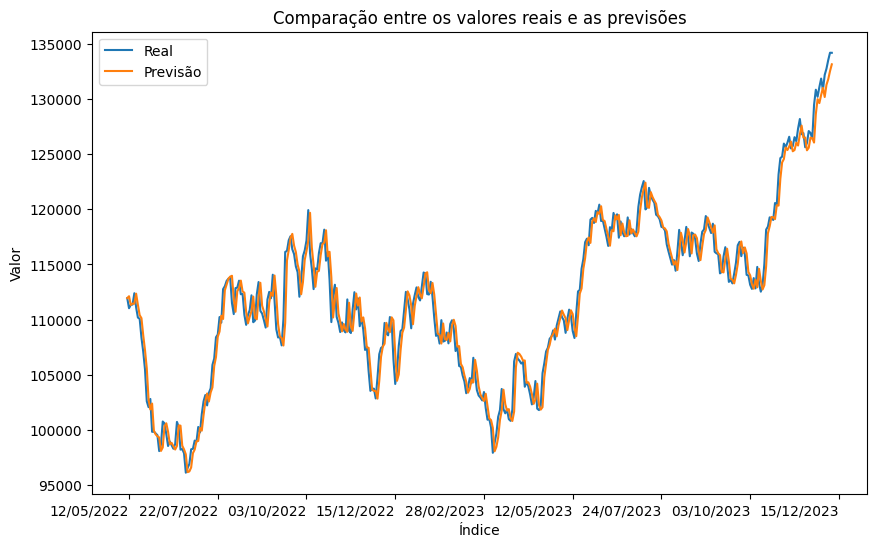

In [ ]:
# Função para carregar o melhor modelo e suas métricas
def load_model_and_metrics(filename):
    # Carregar o modelo e suas métricas
    model = tf.keras.models.load_model(filename + '.keras')
    metrics = {}
    with open(filename + '.txt', 'r') as f:
        for line in f:
            key, value = line.strip().split(': ')
            if key == 'Seed':
                metrics[key] = int(value)
            else:
                metrics[key] = float(value)

    # Carregar o otimizador
    with open(filename + '_optimizer.pkl', 'rb') as f:
        optimizer_config = pickle.load(f)
    optimizer = tf.keras.optimizers.get({'class_name': optimizer_config['name'], 'config': optimizer_config})

    return model, optimizer, metrics

# Caminho do melhor modelo salvo
results_dir = f'/content/drive/MyDrive/Mestrado/Resultados/LSTM/LSTM_p{patience}_bestresults'
best_model_path = os.path.join(results_dir, 'best_model')

# Carregar o melhor modelo e suas métricas
best_model, best_optimizer, best_metrics = load_model_and_metrics(best_model_path)

# Fazer previsões usando o melhor modelo
val_predict = best_model.predict(validation_dataset)
predict = (val_predict * train_std) + train_mean

# Ajustar os dados de entrada e previstos para terem o mesmo tamanho
y_real = test_not_norm[lookback:]
y_predict = predict.squeeze()

# Organizar datas

# Plotar os dados reais e as previsões
plt.figure(figsize=(10, 6))
plt.plot(y_real, label='Real')
plt.plot(y_predict, label='Previsão')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.title('Comparação entre os valores reais e as previsões')
plt.legend()
# Ajustar o eixo x para exibir as datas corretamente
plt.xticks(np.arange(1, len(df_test['Date']), step=50), df_test['Date'][np.arange(df_test.index[0], df_test.index[-1], step=50)])


# Caminho para salvar o arquivo
file_path = f'/content/drive/MyDrive/Mestrado/Resultados/LSTM/LSTM_p{patience}_bestresults/LSTM_1a{runs}runs_p{patience}_comparison_plot_test.png'

# Criar os diretórios necessários
os.makedirs(os.path.dirname(file_path), exist_ok=True)

# Salvar o gráfico
plt.savefig(file_path)

# Mostrar o gráfico
plt.show()

# Carregar e testar novamente o melhor modelo para conferir o resultado

In [ ]:
def load_model_and_metrics(filename):
    # Carregar o modelo e suas métricas
    model = tf.keras.models.load_model(filename + '.keras')
    metrics = {}
    with open(filename + '.txt', 'r') as f:
        for line in f:
            key, value = line.strip().split(': ')
            if key == 'Seed':
                metrics[key] = int(value)  # Corrigi para ler a seed como inteiro
            else:
                metrics[key] = float(value)

    # Carregar o otimizador
    with open(filename + '_optimizer.pkl', 'rb') as f:
        optimizer_config = pickle.load(f)
    optimizer = tf.keras.optimizers.get({'class_name': optimizer_config['name'], 'config': optimizer_config})

    return model, optimizer, metrics

In [ ]:
# Carrega o melhor modelo e suas métricas
best_model, best_optimizer, best_metrics = load_model_and_metrics(os.path.join(results_dir, 'best_model'))
print("Melhor MAPE:", best_metrics['MAPE'])

# Definir a seed para reproduzir os resultados
seed = best_metrics['Seed']
random.seed(seed)
tf.random.set_seed(seed)

Melhor MAPE: 0.9851376858611556


In [ ]:
df = pd.read_csv(f'/content/drive/MyDrive/Mestrado/Resultados/LSTM/LSTM_p{patience}_bestresults/LSTM_1a{runs}runs_p{patience}_test.csv')

# Encontra a linha com o menor valor na coluna MAPE
min_mape_row = df.loc[df['MAPE'].idxmin()]

# Exibe o resultado
print(min_mape_row)


MAE     1.099514e+03
MSE     1.933889e+06
RMSE    1.390643e+03
MAPE    9.851377e-01
R2      9.673800e-01
Run     3.200000e+01
Name: 32, dtype: float64


In [ ]:
# Constrói o modelo LSTM com os melhores parâmetros
def build_model(n_layers, n_units_lstm1, dropout_rate_lstm1, activation_lstm1, n_units_dense, activation_dense, lookback):
    model = Sequential()
    model.add(LSTM(n_units_lstm1, activation=activation_lstm1, input_shape=(lookback, 1)))
    model.add(Dropout(dropout_rate_lstm1))
    model.add(Dense(n_units_dense, activation=activation_dense))
    model.add(Dense(1))
    return model

# Construir e compilar o modelo
model = build_model(n_layers, n_units_lstm1, dropout_rate_lstm1, activation_lstm1, n_units_dense, activation_dense, lookback)
model.compile(optimizer=best_optimizer, loss='mae')

# Definir os callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

# Treinar o modelo
history = model.fit(train_dataset, epochs=200, validation_data=validation_dataset, callbacks=[early_stopping], verbose=1)

# Fazer previsões
val_predict = model.predict(validation_dataset)
predict = (val_predict * train_std) + train_mean

# Ajustar os dados de entrada e previstos para terem o mesmo tamanho
y_real = test_not_norm[lookback:]
y_predict = predict.squeeze()

# Calcular métricas
mae = mean_absolute_error(y_real, y_predict)
mse = mean_squared_error(y_real, y_predict)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_real - y_predict) / y_real)) * 100
r2 = r2_score(y_real, y_predict)

# Imprimir as métricas
print(f"MAE: {mae}, MSE: {mse}, RMSE: {rmse}, MAPE: {mape}, R2: {r2}")

Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - loss: 0.4335 - val_loss: 0.3551
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.5630 - val_loss: 0.1242
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - loss: 0.2669 - val_loss: 0.2355
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - loss: 0.2296 - val_loss: 0.1372
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - loss: 0.2561 - val_loss: 0.5318
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 0.2951 - val_loss: 0.8826
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.3533 - val_loss: 0.0803
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 0.0621 - val_loss: 0.1033
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.1633 - val_loss: 0.2023
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 0.1203 - val_loss: 0.0802
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 0.0873 - val_loss: 0.0741
Epoch 12/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - loss

# Fim